In [1]:
%matplotlib widget

In [1]:
import sys
sys.path.append('../external/tslib')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import csv
import os
import json
import time
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
from dataclasses import dataclass, field
from typing import List, Optional


@dataclass
class Task:
    id: str
    request_time: int
    duration: int
    start_time: Optional[int] = None
    end_time: Optional[int] = None
    assigned_worker: Optional[str] = None

    def __str__(self):
        return f"Task({self.id}|{self.duration}ms|{self.assigned_worker}|{self.request_time}-{self.start_time}-{self.end_time})"

@dataclass
class MetricsDataPoint:
    time: int = 0
    expected_workers: int = 0
    active_workers: int = 0
    total_workers: int = 0
    num_new_tasks: int = 0
    num_ongoing_tasks: int = 0
    num_queued_tasks: int = 0
    num_completed_tasks: int = 0
    avg_delay: float = 0.0
    avg_duration: float = 0.0
    reward: float = 0.0
    completed_tasks: List['Task'] = field(default_factory=list)
    
def generate_reward_function(metrics_window: float, value_per_task: float = 0.001, cost_per_worker_hour: float = 1, delay_threshold: int = 8000) -> float:
    # Example reward function: negative of average delay
    return lambda metrics: (
        sum([0 if (task.end_time - task.request_time) > delay_threshold else value_per_task for task in metrics.completed_tasks]) -
        cost_per_worker_hour * (metrics.total_workers * metrics_window / 3600000 )
    )

class Worker:
    def __init__(self, init_time: int = 0):
        self.id = "worker-" + str(random.randint(0, 10000))
        self.available_at = init_time
        self.active = False  # 是否已经初始化完成

    def assign_task(self, task: Task, current_time: int):
        if current_time < self.available_at:
            task.start_time = self.available_at
            self.available_at += task.duration
        else:
            task.start_time = current_time
            self.available_at = current_time + task.duration
        task.end_time = self.available_at
        task.assigned_worker = self.id
    
    def is_available(self, current_time: int) -> bool:
        return self.available_at <= current_time and self.active
    


class Simulator:
    def __init__(self, tasks: List[Task], init_workers: int = 1, worker_init_time_min : int = 12000, worker_init_time_max : int = 12000, metrics_window: int = 10000, reward_function=None):
        self.tasks = sorted(tasks, key=lambda t: t.request_time)
        self.time = 0  
        self.metrics_window = metrics_window
        self.worker_init_time_min = worker_init_time_min
        self.worker_init_time_max = worker_init_time_max
        self.expected_workers = init_workers
        self.workers = [Worker(self.__get_worker_init_time()) for i in range(init_workers)]
        self.terminating_workers: List[Task] = []
        self.in_progress: List[Task] = []
        self.queued: List[Task] = []
        self.completed_tasks: List[Task] = []

        self.new_tasks = 0
        self.metrics: List[MetricsDataPoint] = []
        self.reward_function = reward_function

    def tick(self): # tick 1s
        self.time += 1000
        # check completed tasks
        for task in self.in_progress:
            if task.end_time <= self.time:
                self.completed_tasks.append(task)
                self.in_progress.remove(task)
        # check initialized workers
        for w in self.workers:
            if not w.active and self.time >= w.available_at:
                w.active = True
        # check terminating workers
        self.terminating_workers = [w for w in self.terminating_workers if w.available_at >= self.time]
        
        worker = self.__get_available_worker(self.time)
        # pop queued tasks
        while worker and self.queued:
            task = self.queued.pop(0)
            worker.assign_task(task, task.request_time)
            self.in_progress.append(task)
            worker = self.__get_available_worker(self.time)
        # pop new tasks
        while self.tasks and self.tasks[0].request_time < self.time:
            task = self.tasks.pop(0)
            self.new_tasks += 1
            if worker:
                worker.assign_task(task, self.time)
                self.in_progress.append(task)
                worker = self.__get_available_worker(self.time)
            else:
                self.queued.append(task)
        # report metrics
        if self.time % self.metrics_window == 0:
            self.report_metrics()

    def scale(self, expected_workers: int):
        if expected_workers > self.expected_workers:
            for _ in range(expected_workers - self.expected_workers):
                worker = Worker(self.time + self.__get_worker_init_time())
                self.workers.append(worker)
        elif expected_workers < self.expected_workers:
            for _ in range(self.expected_workers - expected_workers):
                for w in self.workers:
                    if not w.active:
                        worker = w
                        self.workers.remove(worker)
                        break
                else:
                    worker = self.workers.pop()
                self.terminating_workers.append(worker)
        self.expected_workers = expected_workers

    def report_metrics(self):
        if self.completed_tasks:
            avg_delay = int(np.mean([t.end_time - t.request_time for t in self.completed_tasks]))
            avg_duration = int(np.mean([t.end_time - t.start_time for t in self.completed_tasks]))
        else:
            avg_delay = 0
            avg_duration = 0
        dataPoint = MetricsDataPoint(
            time=self.time,
            expected_workers=self.expected_workers,
            active_workers=len([w for w in self.workers if w.active]),
            total_workers=len(self.workers) + len(self.terminating_workers),
            num_new_tasks=self.new_tasks,
            num_ongoing_tasks=len(self.in_progress) + len(self.queued),
            num_queued_tasks=len(self.queued),
            num_completed_tasks=len(self.completed_tasks),
            avg_delay=avg_delay,
            avg_duration=avg_duration,
            completed_tasks=self.completed_tasks.copy(),
            reward=0,  # Placeholder for reward, to be calculated later
        )
        if self.reward_function:
            dataPoint.reward = self.reward_function(dataPoint)
        self.metrics.append(dataPoint)
        self.completed_tasks.clear()
        self.new_tasks = 0
        
    def plot_metrics(self, tmp_output_dir: str = None):
        metric_keys = [
            'expected_workers',
            'active_workers',
            'total_workers',
            'num_new_tasks',
            'num_ongoing_tasks',
            'num_queued_tasks',
            'num_completed_tasks',
            'avg_delay',
            'avg_duration',
            'reward'
        ]

        data = {key: [] for key in metric_keys}
        time_s = [int(m.time / 1000) for m in self.metrics]

        for metrics in self.metrics:
            for key in metric_keys:
                data[key].append(getattr(metrics, key))

        fig, axes = plt.subplots(len(metric_keys), 1, figsize=(14, 20), sharex=True)

        for ax, key in zip(axes, metric_keys):
            ax.plot(time_s, data[key], label=key)
            ax.set_ylabel(key)
            ax.grid(True)
            ax.legend(loc='upper left')

        axes[-1].set_xlabel("Time (s)")
        fig.tight_layout()
        if tmp_output_dir:
            plt.savefig(os.path.join(tmp_output_dir, "metrics_plot.png"), dpi=300)
        else:
            plt.show()

    def __get_available_worker(self, current_time: int) ->Optional[Worker]:
        # FIFO
        available_worker, min_available_at = None, float('inf')
        for worker in self.workers:
            if worker.is_available(current_time) and worker.available_at < min_available_at:
                min_available_at = worker.available_at
                available_worker = worker
        return available_worker
    
    def __get_worker_init_time(self) -> int:
        return random.randint(self.worker_init_time_min, self.worker_init_time_max)


In [13]:
from datetime import timedelta

def extract_continuous_segment(df, week_count, day_count, time_scale, request_scale):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
    df.sort_values('timestamp', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # 设置时间戳为索引
    df.set_index('timestamp', inplace=True)

    # 获取数据的起始和结束时间
    start_time = df.index.min()
    end_time = df.index.max()

    # 计算所需的总天数
    total_days = week_count * 7 + day_count

    # 查找所有满足条件的连续时间段
    valid_starts = []
    if week_count > 0:
        # 计算所有可能的周一 00:00 的时间点
        valid_starts = pd.date_range(start=start_time, end=end_time - timedelta(days=total_days), freq='W-MON')
    else:
        # 计算所有可能的起始时间点
        valid_starts = pd.date_range(start=start_time, end=end_time - timedelta(days=total_days), freq='D')

    if valid_starts.empty:
        print("❌ 数据中没有满足条件的连续时间段。")
        return

    # 随机选择一个起始时间
    selected_start = random.choice(valid_starts)
    selected_end = selected_start + timedelta(days=total_days)
    print(f"✅ 选中的时间段：{selected_start} 到 {selected_end}")

    # 提取选中的数据段
    segment = df.loc[selected_start:selected_end].copy()
    if segment.empty:
        print("⚠️ 选中的时间段内没有数据。")
        return

    # 重置时间戳，从 0 开始，并应用时间缩放
    segment.reset_index(inplace=True)
    base_time = segment['timestamp'].min()
    segment['timestamp'] = segment['timestamp'].apply(lambda x: int((x - base_time).total_seconds() / time_scale))

    # 应用请求数缩放
    segment['requests'] = segment['requests'] / request_scale

    return segment[['timestamp', 'requests']].reset_index(drop=True), base_time

def schedule_requests_from_csv(requests_df, rate_df):
    # 打乱请求顺序
    requests_df = requests_df.sample(frac=1).reset_index(drop=True)

    result_rows = []
    request_index = 0
    accum = 0.0  # 累积速率

    for _, rate_row in rate_df.iterrows():
        timestamp_base = float(rate_row['timestamp'])
        rps = float(rate_row['requests'])

        accum += rps
        num_requests = int(accum)
        accum -= num_requests  # 保留小数部分

        for _ in range(num_requests):
            if request_index >= len(requests_df):
                break
            row = requests_df.iloc[request_index].copy()
            # 在[T, T+1)内均匀分布]
            row['timestamp'] = timestamp_base + random.uniform(0, 1)
            result_rows.append(row)
            request_index += 1

        if request_index >= len(requests_df):
            break
    
    # sort by timestamp
    result_rows.sort(key=lambda x: x['timestamp'])

    # 创建结果 DataFrame
    return pd.DataFrame(result_rows, columns=['Id', 'Duration', 'timestamp']).rename(columns={'Id': 'id', 'Duration': 'duration'})

def generate_tasks_from_csv(requests_csv_path, rate_csv_path, week_count=0, day_count=3, scale = 0.8, tmp_output_dir = None):
    # 读取请求数据
    requests_df = pd.read_csv(requests_csv_path)
    rate_df = pd.read_csv(rate_csv_path)

    # 提取连续时间段
    segment, base_time = extract_continuous_segment(rate_df, week_count, day_count, 120, 120 * 1 / scale)
    if segment is None:
        return None
    
    tasks_df = schedule_requests_from_csv(requests_df, segment)
    if tasks_df is None:
        return None
    
    time_start = tasks_df['timestamp'].min() 
    tasks_df['timestamp'] = tasks_df['timestamp'].apply(lambda x: int((x - time_start) * 1000))  # 转换为毫秒
    tasks_df['id'] = tasks_df['id'].astype(int)
    tasks_df['duration'] = tasks_df['duration'].astype(int)

    if tmp_output_dir:
        tmp_output_path = os.path.join(tmp_output_dir, 'tasks.csv')
        if not os.path.exists(tmp_output_dir):
            os.makedirs(tmp_output_dir)
        tasks_df.to_csv(tmp_output_path, index=False)
        print(f"✅ 生成的任务数据已保存到 {tmp_output_path}")
        # 保存basetime等元信息为json文件
        meta_info = {'base_time': base_time.isoformat(), 'week_count': week_count, 'day_count': day_count, 'scale': scale}
        meta_info_path = os.path.join(tmp_output_dir, 'meta_info.json')
        with open(meta_info_path, 'w') as f:
            json.dump(meta_info, f)
        print(f"✅ 生成的元数据已保存到 {meta_info_path}")

    tasks = [Task(id=row['id'], request_time=row['timestamp'], duration=row['duration']) for _, row in tasks_df.iterrows()]
    return tasks, base_time

def load_tasks_from_csv(tmp_output_dir = 'rl/tmp'):
    tasks_df = pd.read_csv(os.path.join(tmp_output_dir, 'tasks.csv'))
    tasks = [Task(id=row['id'], request_time=row['timestamp'], duration=row['duration']) for _, row in tasks_df.iterrows()]
    # 读取元信息
    with open(os.path.join(tmp_output_dir, 'meta_info.json'), 'r') as f:
        meta_info = json.load(f)
        base_time = pd.to_datetime(meta_info['base_time'])

    return tasks, base_time

def save_metrics_to_csv(metric_history, tmp_output_dir = 'rl/tmp'):
    os.makedirs(tmp_output_dir, exist_ok=True)

    # Build DataFrame
    df = pd.DataFrame(metric_history)
    df['time'] = df['time'].apply(lambda x: int(x / 1000)) 
    df['reward'] = df['reward'].apply(lambda x: round(x, 4))
    df['completed_tasks'] = df['completed_tasks'].apply(lambda x: ','.join([f"Task({t['id']}|{t['duration']}ms|{t['assigned_worker']}|{t['request_time']}-{t['start_time']}-{t['end_time']})" for t in x]))

    # Write to CSV
    out_path = os.path.join(tmp_output_dir, 'metrics.csv')
    df.to_csv(out_path, index=False)
    print(f"✅ 生成的指标数据已保存到 {out_path}")
    

def preprocess_experiment_result(result_csv_path):
    # 读取 CSV 文件
    df1 = pd.read_csv(result_csv_path)
    # 列名映射
    column_map = {
        'Time': 'time',
        'Expected Worker': 'expected_workers',
        'Running Worker': 'active_workers',
        'Total Worker': 'total_workers',
        'New Job': 'num_new_tasks',
        'Ongoing Job': 'num_ongoing_tasks',
        'Completed Job': 'num_completed_tasks',
        'Avg Duration': 'avg_duration',
        'Avg Delay': 'avg_delay',
        'Reward': 'reward',  # 累积值
    }
    df1 = df1.rename(columns=column_map)
    df1 = df1.sort_values('time').reset_index(drop=True)

    # 将 reward 转为增量
    df1['reward'] = df1['reward'].diff().fillna(df1['reward'])

    return df1

def compare_metrics(df1, df2):

    # 获取共有列（排除 time）
    common_columns = [col for col in df1.columns if col in df2.columns and col != 'time']
    n = len(common_columns)

    # 创建子图（n 行 1 列）
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(14, 3 * n), sharex=True)

    # 如果只有一个指标，axes 不是列表
    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, common_columns):
        ax.plot(df1["time"], df1[col], label="Source 1")
        ax.plot(df2["time"], df2[col], label="Source 2")
        ax.set_ylabel(col)
        ax.legend()
        ax.grid(True)

    axes[-1].set_xlabel("Time")
    fig.tight_layout()
    plt.show()

In [14]:
day_count = 3
scale = 1
request_mean = 3.69341263 * scale
request_std = 2.05966675 * scale
iterations = 60 * 12 * day_count
init_workers = 1
min_workers = 1
max_workers = 3
worker_init_time_min = 12
worker_init_time_max = 12
metrics_window = 10
forecast_window = 36
observe_length = 3
future_length = 3
reward_function = generate_reward_function(metrics_window * 1000, value_per_task=0.002, cost_per_worker_hour=1, delay_threshold=8000)

In [6]:
tasks, base_time = generate_tasks_from_csv(
    requests_csv_path='../data/test_regression_clipped.csv',
    rate_csv_path='../data/request_timeseries_test.csv',
    week_count=0,
    day_count=day_count,
    scale=scale,
    tmp_output_dir='rl/tmp'
)

✅ 选中的时间段：2025-03-22 15:26:00 到 2025-03-25 15:26:00
✅ 生成的任务数据已保存到 rl/tmp/tasks.csv
✅ 生成的元数据已保存到 rl/tmp/meta_info.json


In [7]:
merge_tasks_param_csv(
    tasks_param_csv_path='../data/test.csv',
    output_path='../experiment/input/test.csv',
    tmp_output_dir='rl/tmp'
)

🤩 总reward为： -0.4879999999999988
✅ 生成的指标数据已保存到 rl/tmp/metrics.csv


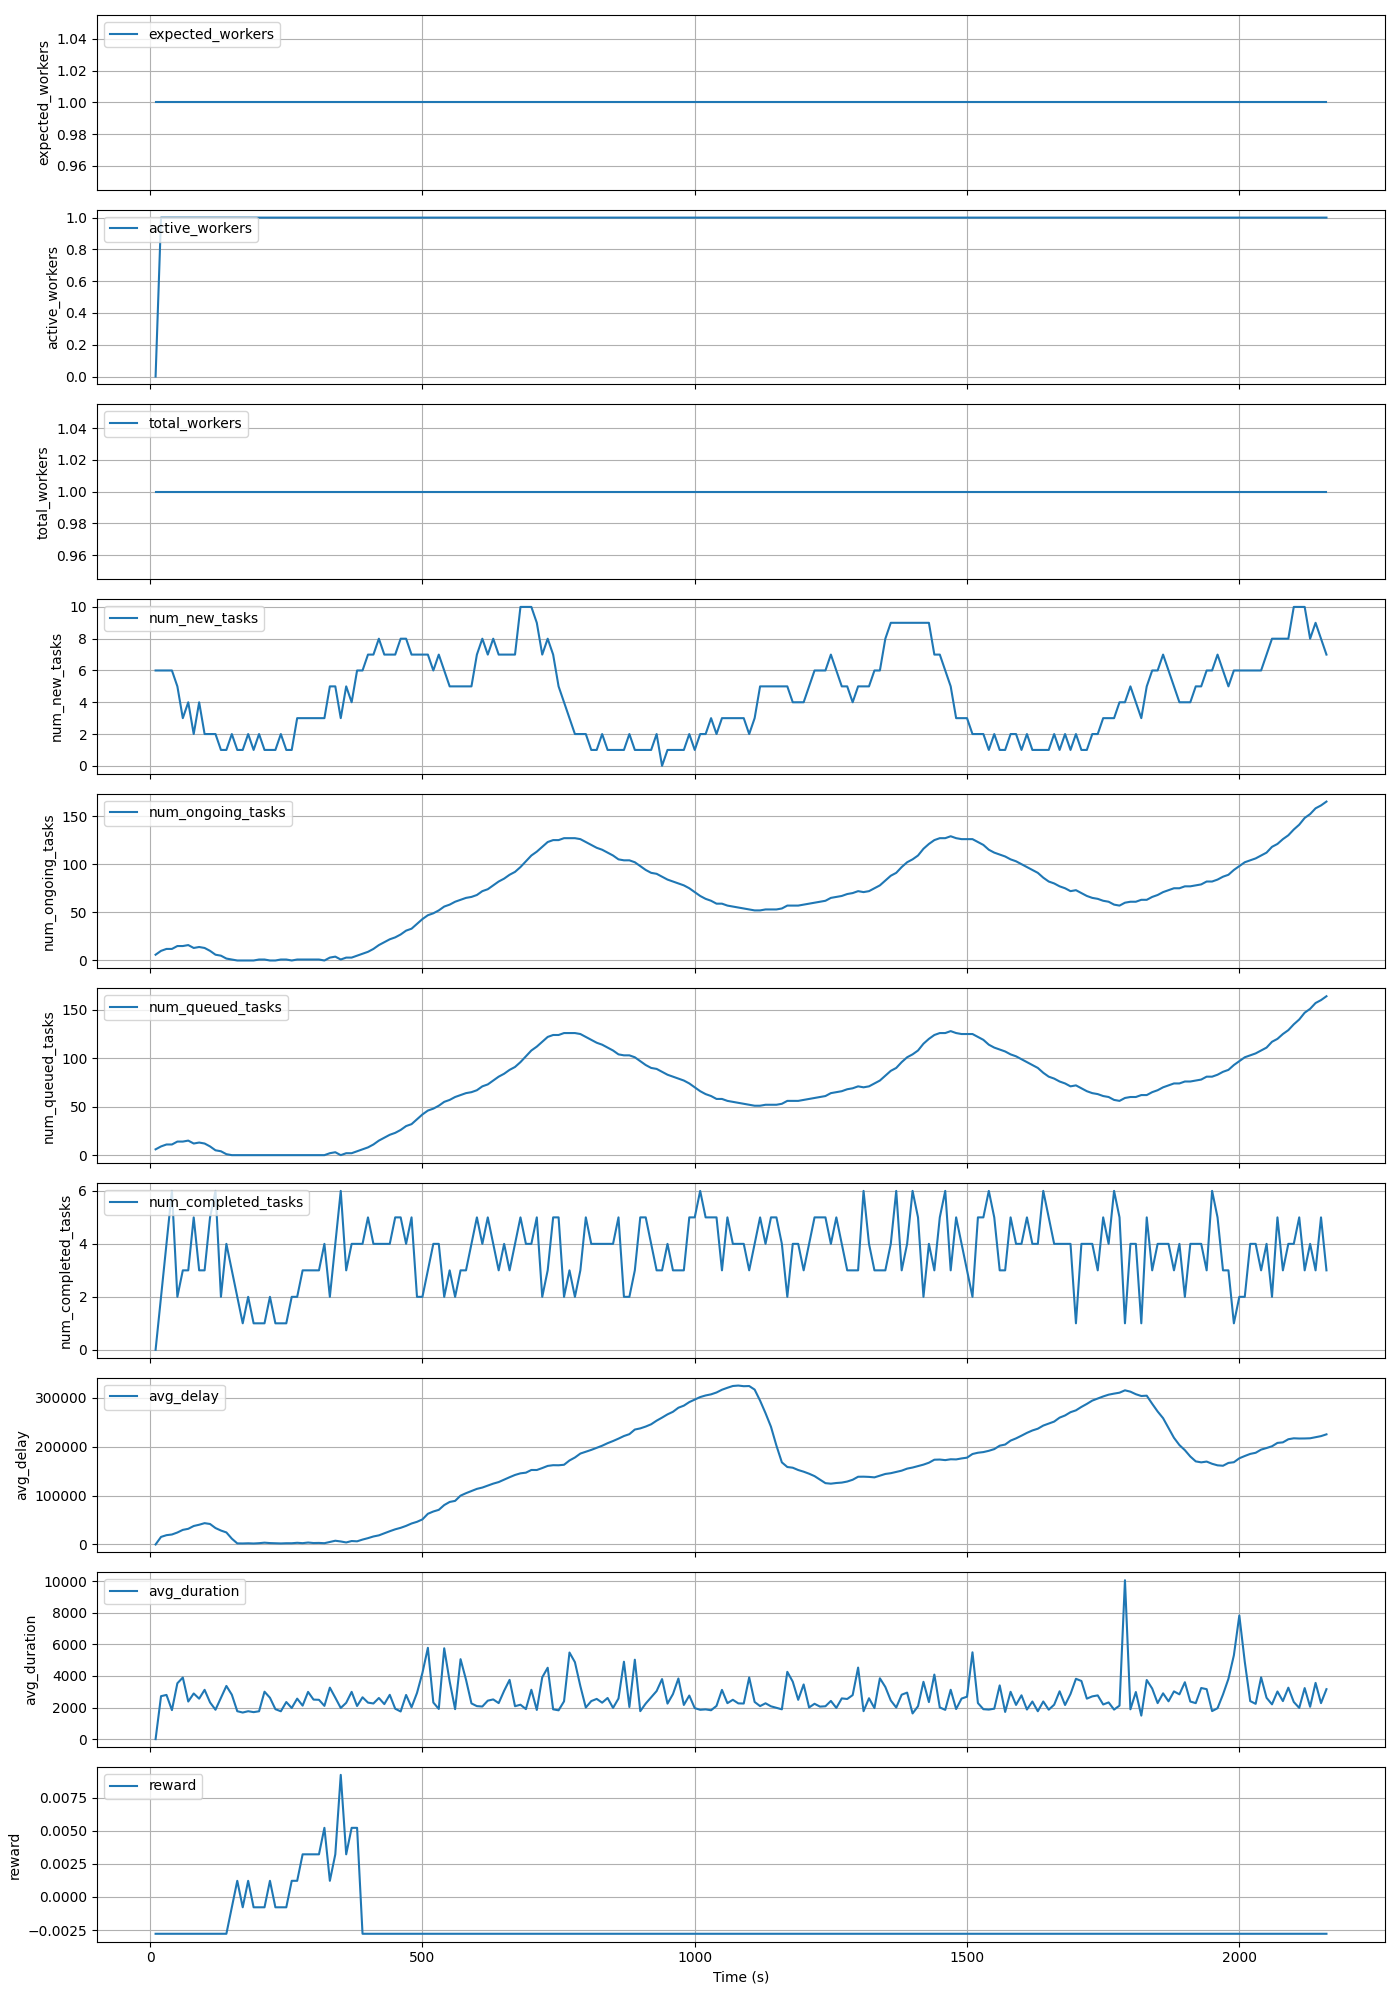

In [8]:
tasks, _ = load_tasks_from_csv('rl/tmp')
simulator = Simulator(tasks, 1, worker_init_time * 1000, metrics_window * 1000,
                      reward_function=reward_function
)
for i in range(iterations):
    simulator.tick()

print("🤩 总reward为：", sum([m.reward for m in simulator.metrics]))
simulator.plot_metrics("rl/tmp")
save_metrics_to_csv(simulator.metrics, 'rl/tmp')

In [15]:
class QueueSizeScaleStrategy:
    def __init__(self, 
                 min_workers: int = min_workers,
                 max_workers: int = max_workers,
                 aggressive_scale: bool = False,
                 target_ongoing_tasks: int = 2, 
                 scale_up_window: int = 1, 
                 scale_down_window: int = 1):
        self.min_workers = min_workers
        self.max_workers = max_workers
        self.aggressive_scale = aggressive_scale
        self.target_ongoing_tasks = target_ongoing_tasks
        self.scale_up_window = scale_up_window
        self.scale_down_window = scale_down_window

    def calc(self, current_expected_workers: int, metrics: List[MetricsDataPoint]) -> int:
        if len(metrics) < self.scale_up_window or len(metrics) < self.scale_down_window:
            return current_expected_workers
        # Calculate the average number of ongoing tasks over the last scale_up_window iterations
        avg_ongoing_tasks_up = np.mean([m.num_ongoing_tasks + m.num_new_tasks  for m in metrics[-self.scale_up_window:]])
        # Calculate the average number of ongoing tasks over the last scale_down_window iterations
        avg_ongoing_tasks_down = np.mean([m.num_ongoing_tasks + m.num_new_tasks  for m in metrics[-self.scale_down_window:]])
        # Scale up if the average number of ongoing tasks is greater than the target
        new_workers = current_expected_workers
        running_workers = max(1, metrics[-1].active_workers)
        if avg_ongoing_tasks_up > self.target_ongoing_tasks * running_workers:
            new_workers = np.ceil(avg_ongoing_tasks_up / self.target_ongoing_tasks)
            if not self.aggressive_scale and new_workers > current_expected_workers:
                new_workers = current_expected_workers + 1
            new_workers = min(new_workers, self.max_workers)

        if avg_ongoing_tasks_down < self.target_ongoing_tasks * running_workers:
            new_workers = np.ceil(avg_ongoing_tasks_down / self.target_ongoing_tasks)
            if not self.aggressive_scale and new_workers < current_expected_workers:
                new_workers = current_expected_workers - 1
            new_workers = max(new_workers, self.min_workers)

        return int(new_workers)

🤩 总reward为： 0.662666666666668
✅ 生成的指标数据已保存到 rl/tmp/metrics.csv


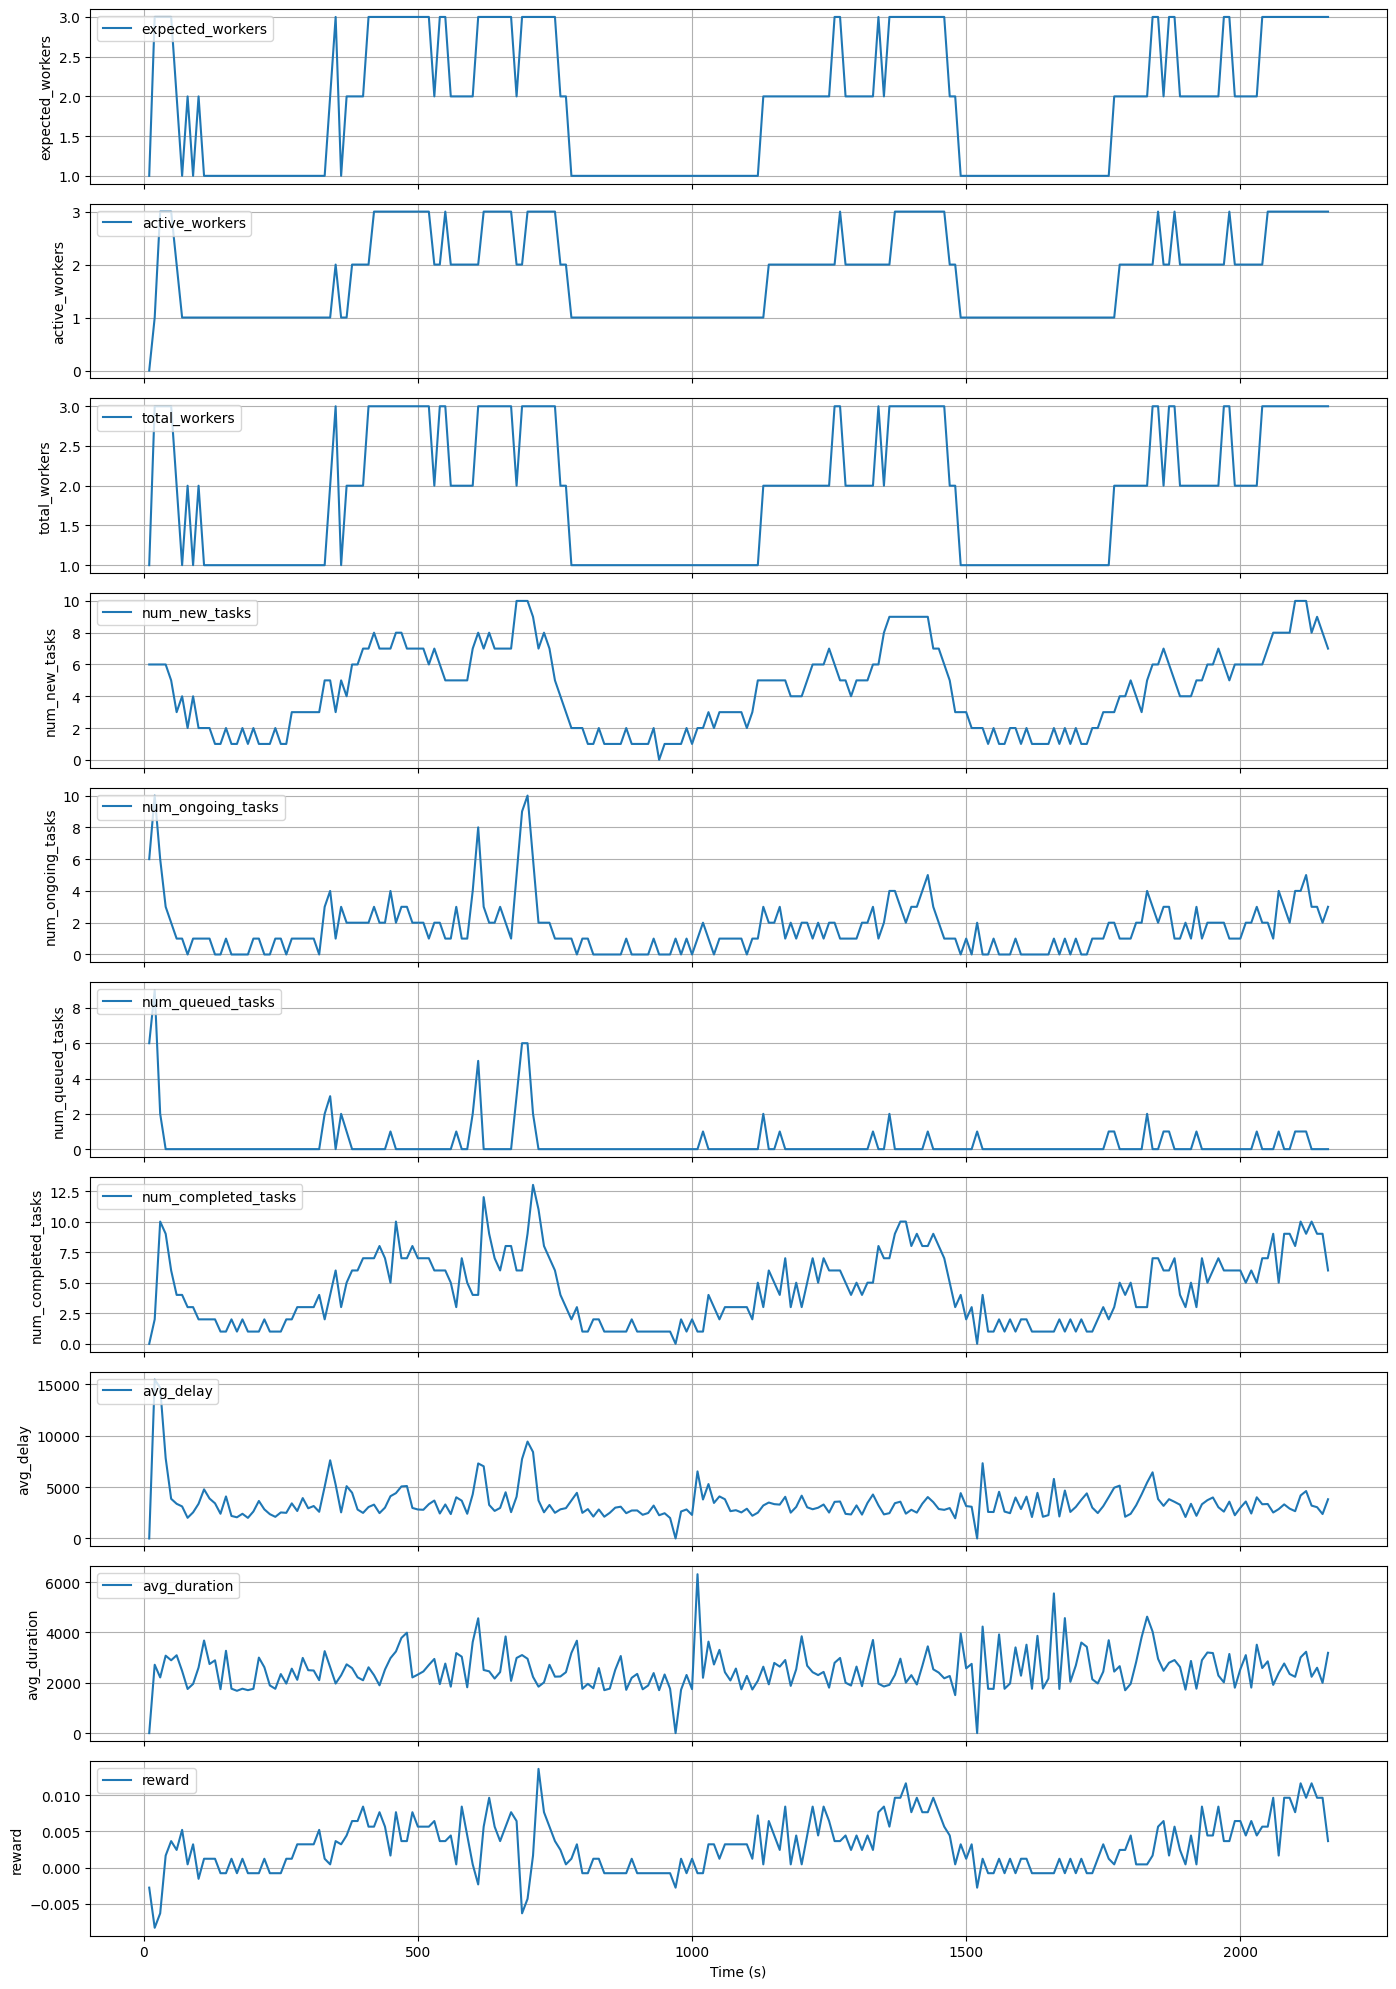

In [19]:
strategy = QueueSizeScaleStrategy(
    min_workers=min_workers,
    max_workers=max_workers,
    aggressive_scale=True,
    target_ongoing_tasks=4,
    scale_up_window=1,
    scale_down_window=1
)
tasks, _ = load_tasks_from_csv('rl/tmp')
simulator = Simulator(tasks, init_workers, worker_init_time * 1000, metrics_window * 1000,
                      reward_function=reward_function
)
for i in range(iterations):
    simulator.tick()
    if i > 0 and i % metrics_window == 0:
        expected_workers = strategy.calc(simulator.expected_workers, simulator.metrics)
        simulator.scale(expected_workers)
print("🤩 总reward为：", sum([m.reward for m in simulator.metrics]))
simulator.plot_metrics("rl/tmp")
save_metrics_to_csv(simulator.metrics, 'rl/tmp')

In [20]:

import gymnasium as gym
from gymnasium.spaces import Discrete, Box
from lib.forecast.tslib_util import (
    TimeseriesForecaster,
    TimeseriesTransformer
)

class WorkerScaling(gym.Env):

    FEATURE_MIN = {
        "running_workers": 0,
        "new_requests": 0,
        "ongoing_requests": 0,
        "finished_requests": 0,
        "requests_delay": 0.0,
        "requests_duration": 0.0,
        "forecasted_requests": 0.0,
    }

    FEATURE_MAX = {
        "running_workers": max_workers,         
        "new_requests": scale * 10,            
        "ongoing_requests": scale * 50,        
        "finished_requests": max_workers * 6,       
        "requests_delay": scale * 20000,          
        "requests_duration": 12000, 
        "forecasted_requests": scale * 10,      
    }

    def __init__(self, config: Optional[dict] = None):
        self.config = config or {}
        self.observe_length = self.config.get("observe_length", 36)
        self.future_length = self.config.get("future_length", 36)
        self.action_space = Discrete(max_workers)
        self.observation_space = Box(0.0, 1.0, shape=(self.observe_length * 6 + self.future_length,), dtype=np.float32)
        self.time_s = 0

        self.forecaster = TimeseriesForecaster()

        random.seed(int(seed + self.config.get("worker_index", 0)) % 99999)
        np.random.seed(int(seed + self.config.get("worker_index", 0)) % 99999)


    def reset(self, *, seed=None, options=None):
        self.time_s = 0
        self.init_simulator()
        # Return obs and (empty) info dict.
        return self.extract_observation_window(self.simulator.metrics), {"env_state": "reset"}

    def step(self, action):
        assert action in range(max_workers), f"Invalid action {action}"
        
        self.simulator.scale(action + min_workers)
        for _ in range(metrics_window):
            self.simulator.tick()
            self.time_s += 1
            if self.time_s >= iterations:
                break

        terminated = self.time_s >= iterations
        truncated = False


        reward = self.simulator.metrics[-1].reward
        infos = {}
        return (
            self.extract_observation_window(self.simulator.metrics),
            reward,
            terminated,
            truncated,
            infos,
        )
    
    def init_simulator(self, tasks=None, base_time=None):
        if tasks is None:
            tasks, base_time = generate_tasks_from_csv(
                requests_csv_path='../data/train_regression_clipped.csv',
                rate_csv_path='../data/request_timeseries_train.csv',
                week_count=0,
                day_count=day_count,
                scale=scale,
            )
        self.simulator = Simulator(tasks, 1, worker_init_time_min* 1000, worker_init_time_max *1000, metrics_window * 1000, reward_function)

        self.forecaster.setTransformer(
            transformer=TimeseriesTransformer(
                date_start=base_time.timestamp(), date_scale=120, scale=True,
                scale_mean=request_mean, scale_std=request_std
            )
        )

        self.iteration = 0
        self.max_iterations = len(tasks) * 2

    
    def extract_observation_window(self, data: List[MetricsDataPoint]) -> np.ndarray:

        # get forecasted data

        obs = np.zeros((self.observe_length * 6 + self.future_length,), dtype=np.float32)
        if len(data) == 0:
            return obs

        if len(data) >= forecast_window:
            forecast_metrics =  data[-forecast_window:]
            recent_new_request = [0 if not m else m.num_new_tasks for m in forecast_metrics]
            recent_timestamp = [self.time_s - i * metrics_window for i in range(forecast_window-1, -1, -1)]
            future_requests = self.forecaster.forecast(
                enc_data=recent_new_request,
                enc_stamp=recent_timestamp,
            )[:self.future_length]
        else:
            future_requests = np.zeros(self.future_length, dtype=np.float32)

        # print(f"Recent requests:{recent_new_request} \n---\n Forecasted future requests: {future_requests}")

        recent = data[-self.observe_length:] if len(data) >= self.observe_length else [None] * (self.observe_length - len(data)) + data
        for i, point in enumerate(recent + list(future_requests)):
            if point is None:
                continue  # Keep default zeros for padding

            observed = isinstance(point, MetricsDataPoint)
            features = [
                ("running_workers", point.active_workers),
                ("requests_delay", point.avg_delay),
                ("requests_duration", point.avg_duration),
                ("ongoing_requests", point.num_ongoing_tasks),
                ("finished_requests", point.num_completed_tasks),
                ("new_requests", point.num_new_tasks)
            ] if observed else [
                ("new_requests", point)
            ]

            for row, (key, raw_value) in enumerate(features):
                min_val = WorkerScaling.FEATURE_MIN[key]
                max_val = WorkerScaling.FEATURE_MAX[key]
                # Min-max normalization with small epsilon for safety
                norm_val = (raw_value - min_val) / (max_val - min_val + 1e-6)
                norm_val = np.clip(norm_val, 0.0, 1.0)
                if i < self.observe_length:
                    obs[row * self.observe_length + i] = norm_val
                else:
                    obs[6 * self.observe_length + i - self.observe_length] = norm_val

        return obs

In [51]:
from ray.tune import Callback
from ray.rllib.utils.test_utils import (
    add_rllib_example_script_args,
    run_rllib_example_script_experiment,
)
from ray.rllib.utils.metrics import (
    ENV_RUNNER_RESULTS,
    EPISODE_RETURN_MEAN,
)
from ray.rllib.core.rl_module.rl_module import RLModuleSpec
from ray.rllib.core.rl_module.default_model_config import DefaultModelConfig
from ray.rllib.algorithms.ppo.torch.default_ppo_torch_rl_module import DefaultPPOTorchRLModule
from ray.rllib.algorithms.ppo import PPOConfig

import lib.model.transformer as transformer

parser = add_rllib_example_script_args(
    default_reward=1.5, default_iters=200, default_timesteps=1000000
)
parser.set_defaults(
    # Make sure that - by default - we produce checkpoints during training.
    checkpoint_freq=10,
    checkpoint_at_end=True,
    # Script only runs on new API stack.
    enable_new_api_stack=True,
)
args = parser.parse_args([])

iter_setps, episode_reward = [], []
class TuneCallback(Callback):
    def on_trial_result(self, iteration, trials, trial, result,
                        **info):
        if result.get(ENV_RUNNER_RESULTS) and result.get(ENV_RUNNER_RESULTS).get(EPISODE_RETURN_MEAN):
            print(f"🤩 step{iteration} 平均reward为 {result[ENV_RUNNER_RESULTS][EPISODE_RETURN_MEAN]}")
            iter_setps.append(iteration)
            episode_reward.append(result[ENV_RUNNER_RESULTS][EPISODE_RETURN_MEAN])

base_config = (
        PPOConfig()
        .api_stack(
            enable_rl_module_and_learner=True,
            enable_env_runner_and_connector_v2=True,
        )
        .rl_module(
            model_config=DefaultModelConfig(
                # fcnet_hiddens=[128, 128],
                fcnet_activation="relu",
                # head_fcnet_hiddens=[32, 32],
                vf_share_layers=True,
            )
        )
        # .rl_module(
        #     rl_module_spec=RLModuleSpec(
        #         module_class=DefaultPPOTorchRLModule,
        #         catalog_class=transformer.TransformerEncoderCatalog,
        #         model_config={
        #             "head_fcnet_hiddens": [128,128],
        #             "head_fcnet_activation": "relu",
        #             "vf_share_layers": True,
        #             "d_model": 128,
        #             "n_layer": 2,
        #             "embedding_dropout": 0,
        #             "embedding_bias": False,
        #             "embedding_position_type": "",
        #         },
        #     ),
        # )
        .env_runners(num_env_runners=8, num_gpus_per_env_runner=0, num_cpus_per_env_runner=0.1)
        .learners(num_gpus_per_learner=1, num_cpus_per_learner=1)
        .training(
            train_batch_size_per_learner = 2000,
            lambda_ = 0.97,
            vf_loss_coeff = 1,
            kl_coeff = 0.2,
            lr = 3e-4
        )
        .environment(
            WorkerScaling,
            env_config={"observe_length": observe_length, "future_length": future_length}
        )

    )

results = run_rllib_example_script_experiment(base_config, args, tune_callbacks=[TuneCallback()])

best_result = results.get_best_result(
    metric=f"{ENV_RUNNER_RESULTS}/{EPISODE_RETURN_MEAN}", mode="max"
)
print(f"Best result: {best_result}")

2025-05-20 07:53:56,016	INFO worker.py:1888 -- Started a local Ray instance.


(PPO pid=66070) 2025-05-20 07:54:08,225	WARNING algorithm_config.py:4766 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html


(SingleAgentEnvRunner pid=66136) Using cpu or mps
(SingleAgentEnvRunner pid=66136) Use CPU


(SingleAgentEnvRunner pid=66136) 2025-05-20 07:54:26,701	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!
(PPO pid=66070) Trainable.setup took 21.034 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=66070) Install gputil for GPU system monitoring.


(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-01-05 13:00:00 到 2025-01-08 13:00:00
(SingleAgentEnvRunner pid=66141) Using cpu or mps [repeated 7x across cluster]
(SingleAgentEnvRunner pid=66141) Use CPU [repeated 7x across cluster]
(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-01-26 13:00:00 到 2025-01-29 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2025-02-16 13:00:00 到 2025-02-19 13:00:00 [repeated 6x across cluster]
🤩 step744 平均reward为 -0.09765277777777777


Trial name,env_runner_group,env_runners,fault_tolerance,learners,num_env_steps_sampled_lifetime,num_env_steps_sampled_lifetime_throughput,num_training_step_calls_per_iteration,perf,timers
PPO_WorkerScaling_c3e2f_00000,{'actor_manager_num_outstanding_async_reqs': 0},"{'num_module_steps_sampled': {'default_policy': 2000}, 'episode_return_min': 0.3307777777777787, 'episode_len_mean': 216.0, 'module_to_env_connector': {'connector_pipeline_timer': np.float64(0.0014452667292199249), 'timers': {'connectors': {'remove_single_ts_time_rank_from_batch': np.float64(7.504208755714865e-06), 'un_batch_to_individual_items': np.float64(6.518485387421209e-05), 'listify_data_for_vector_env': np.float64(0.0001235592694250331), 'normalize_and_clip_actions': np.float64(0.00011042907623653734), 'get_actions': np.float64(0.0006448131028583241), 'tensor_to_numpy': np.float64(0.00020561938421219197)}}}, 'num_module_steps_sampled_lifetime': {'default_policy': 400000}, 'env_reset_timer': np.float64(2.2797914155007675), 'num_agent_steps_sampled_lifetime': {'default_agent': 400000}, 'env_to_module_connector': {'timers': {'connectors': {'add_observations_from_episodes_to_batch': np.float64(3.599341986870943e-05), 'add_states_from_episodes_to_batch': np.float64(1.782324471920001e-05), 'numpy_to_tensor': np.float64(0.00014522870225714156), 'add_time_dim_to_batch_and_zero_pad': np.float64(3.3154137448502634e-05), 'batch_individual_items': np.float64(8.655294719377161e-05)}}, 'connector_pipeline_timer': np.float64(0.0005438934679167711)}, 'episode_return_max': 0.9121111111111134, 'episode_duration_sec_mean': 19.779181262539097, 'num_episodes_lifetime': 1848, 'rlmodule_inference_timer': np.float64(0.000498681085474027), 'num_episodes': 8, 'episode_len_min': 216, 'episode_return_mean': 0.5644401709401716, 'env_to_module_sum_episodes_length_out': np.float64(93.80785496779632), 'episode_len_max': 216, 'num_agent_steps_sampled': {'default_agent': 2000}, 'env_step_timer': np.float64(0.09891967745545552), 'num_env_steps_sampled_lifetime': 400000, 'weights_seq_no': 199.0, 'agent_episode_returns_mean': {'default_agent': 0.5644401709401716}, 'module_episode_returns_mean': {'default_policy': 0.5644401709401716}, 'num_env_steps_sampled': 2000, 'sample': np.float64(29.620736162568154), 'env_to_module_sum_episodes_length_in': np.float64(93.80785496779632), 'time_between_sampling': np.float64(10.950372019592903), 'num_env_steps_sampled_lifetime_throughput': 58.93730781688902}","{'num_healthy_workers': 8, 'num_remote_worker_restarts': 0}","{'default_policy': {'num_trainable_parameters': 72452.0, 'default_optimizer_learning_rate': 5e-05, 'diff_num_grad_updates_vs_sampler_policy': np.float32(1.0), 'policy_loss': np.float32(0.06732938), 'weights_seq_no': 200.0, 'vf_loss_unclipped': np.float32(0.005374824), 'total_loss': np.float32(0.07270422), 'gradients_default_optimizer_global_norm': np.float32(1.5415748), 'module_train_batch_size_mean': 128.0, 'vf_explained_var': np.float32(0.09267789), 'entropy': np.float32(0.07212516), 'curr_kl_coeff': 0.0, 'num_module_steps_trained': 60544, 'curr_entropy_coeff': 0.0, 'mean_kl_loss': np.float32(0.0015140013), 'num_module_steps_trained_lifetime': 12116480, 'vf_loss': np.float32(0.005374824)}, '__all_modules__': {'num_module_steps_trained': 60544, 'learner_connector': {'timers': {'connectors': {'batch_individual_items': 0.05427315723085001, 'add_observations_from_episodes_to_batch': 0.00037933186828364475, 'add_one_ts_to_episodes_and_truncate': 0.006710344997658775, 'add_columns_from_episodes_to_train_batch': 0.08158632302199648, 'general_advantage_estimation': 0.06273410615601535, 'add_states_from_episodes_to_batch': 1.2848742703638637e-05, 'numpy_to_tensor': 0.0013586231886538996, 'add_time_dim_to_batch_and_zero_pad': 3.460532953437705e-05}}, 'connector_pipeline_timer': 0.2075755301134042}, 'num_module_steps_trained_lifetime': 12116480, 'learner_connector_sum_episodes_length_out': 2016.713326666458, 'num_trainable_parameters': 72452.0, 'num_

(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2024-12-27 13:00:00 到 2024-12-30 13:00:00 [repeated 2x across cluster]
🤩 step1123 平均reward为 -0.2887895299145297
(SingleAgentEnvRunner pid=66139) ✅ 选中的时间段：2025-03-06 13:00:00 到 2025-03-09 13:00:00 [repeated 8x across cluster]
🤩 step1519 平均reward为 -0.23133547008546992
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-01-29 13:00:00 到 2025-02-01 13:00:00 [repeated 8x across cluster]
🤩 step1915 平均reward为 -0.11399465811965816
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-01-31 13:00:00 到 2025-02-03 13:00:00 [repeated 8x across cluster]
🤩 step2307 平均reward为 0.005860042735042709
(SingleAgentEnvRunner pid=66141) ✅ 选中的时间段：2025-03-01 13:00:00 到 2025-03-04 13:00:00 [repeated 8x across cluster]
🤩 step2697 平均reward为 0.05070619658119657
(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2025-01-08 13:00:00 到 2025-01-11 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-02-08 13:00:00 到 2025-02-11 13:00:00 [repeated 8x across cluster]
🤩

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000000)
(PPO pid=66070) 2025-05-20 07:54:29,132	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future! [repeated 8x across cluster]


(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-03-06 13:00:00 到 2025-03-09 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66139) ✅ 选中的时间段：2025-02-09 13:00:00 到 2025-02-12 13:00:00 [repeated 7x across cluster]
🤩 step4747 平均reward为 0.17462713675213676
(SingleAgentEnvRunner pid=66139) ✅ 选中的时间段：2025-02-28 13:00:00 到 2025-03-03 13:00:00
(SingleAgentEnvRunner pid=66141) ✅ 选中的时间段：2025-03-03 13:00:00 到 2025-03-06 13:00:00
🤩 step5139 平均reward为 0.2684102564102564
(SingleAgentEnvRunner pid=66139) ✅ 选中的时间段：2025-01-13 13:00:00 到 2025-01-16 13:00:00 [repeated 7x across cluster]
(SingleAgentEnvRunner pid=66136) ✅ 选中的时间段：2025-02-25 13:00:00 到 2025-02-28 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-02-22 13:00:00 到 2025-02-25 13:00:00 [repeated 5x across cluster]
🤩 step5567 平均reward为 0.24967307692307697
(SingleAgentEnvRunner pid=66139) ✅ 选中的时间段：2025-02-10 13:00:00 到 2025-02-13 13:00:00 [repeated 3x across cluster]
🤩 step5971 平均reward为 0.251832264

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000001)


(SingleAgentEnvRunner pid=66139) ✅ 选中的时间段：2025-02-11 13:00:00 到 2025-02-14 13:00:00 [repeated 4x across cluster]
🤩 step8783 平均reward为 0.34583760683760695
(SingleAgentEnvRunner pid=66136) ✅ 选中的时间段：2025-02-13 13:00:00 到 2025-02-16 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66141) ✅ 选中的时间段：2025-02-03 13:00:00 到 2025-02-06 13:00:00 [repeated 6x across cluster]
🤩 step9188 平均reward为 0.327284188034188
(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-02-06 13:00:00 到 2025-02-09 13:00:00 [repeated 2x across cluster]
🤩 step9564 平均reward为 0.30921474358974366
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-01-16 13:00:00 到 2025-01-19 13:00:00 [repeated 8x across cluster]
🤩 step9973 平均reward为 0.3746698717948719
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-01-20 13:00:00 到 2025-01-23 13:00:00 [repeated 8x across cluster]
🤩 step10348 平均reward为 0.3866570512820513
(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2025-03-07 13:00:00 到 2025-03-10 13:00:00 [repeated 8x across cluster]
(Single

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000002)


(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-02-08 13:00:00 到 2025-02-11 13:00:00 [repeated 8x across cluster]
🤩 step12659 平均reward为 0.32234829059829057
(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-02-27 13:00:00 到 2025-03-02 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66136) ✅ 选中的时间段：2025-02-20 13:00:00 到 2025-02-23 13:00:00 [repeated 8x across cluster]
🤩 step13045 平均reward为 0.37839529914529935
(SingleAgentEnvRunner pid=66139) ✅ 选中的时间段：2025-01-04 13:00:00 到 2025-01-07 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66141) ✅ 选中的时间段：2025-02-16 13:00:00 到 2025-02-19 13:00:00 [repeated 7x across cluster]
🤩 step13454 平均reward为 0.3834188034188037
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-01-01 13:00:00 到 2025-01-04 13:00:00
(SingleAgentEnvRunner pid=66141) ✅ 选中的时间段：2025-01-02 13:00:00 到 2025-01-05 13:00:00
🤩 step13835 平均reward为 0.4387510683760688
(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-01-22 13:00:00 到 2025-01-25 13:00:00 [repeated 7x acro

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000003)


(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-01-27 13:00:00 到 2025-01-30 13:00:00 [repeated 2x across cluster]
🤩 step16521 平均reward为 0.4717029914529916
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-01-27 13:00:00 到 2025-01-30 13:00:00 [repeated 8x across cluster]
🤩 step16892 平均reward为 0.5536923076923079
(SingleAgentEnvRunner pid=66138) ✅ 选中的时间段：2025-03-01 13:00:00 到 2025-03-04 13:00:00 [repeated 8x across cluster]
🤩 step17321 平均reward为 0.48738034188034185
(SingleAgentEnvRunner pid=66138) ✅ 选中的时间段：2025-01-06 13:00:00 到 2025-01-09 13:00:00 [repeated 8x across cluster]
🤩 step17700 平均reward为 0.4342542735042735
(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2025-01-31 13:00:00 到 2025-02-03 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2025-01-18 13:00:00 到 2025-01-21 13:00:00 [repeated 8x across cluster]
🤩 step18088 平均reward为 0.44609081196581263
(SingleAgentEnvRunner pid=66139) ✅ 选中的时间段：2025-01-17 13:00:00 到 2025-01-20 13:00:00 [repeated 8x across cluster]
🤩 

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000004)


(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-03-08 13:00:00 到 2025-03-11 13:00:00 [repeated 7x across cluster]
(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-01-31 13:00:00 到 2025-02-03 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66136) ✅ 选中的时间段：2024-12-24 13:00:00 到 2024-12-27 13:00:00 [repeated 4x across cluster]
🤩 step20545 平均reward为 0.4634583333333341
(SingleAgentEnvRunner pid=66138) ✅ 选中的时间段：2025-01-14 13:00:00 到 2025-01-17 13:00:00 [repeated 4x across cluster]
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2024-12-27 13:00:00 到 2024-12-30 13:00:00 [repeated 5x across cluster]
🤩 step20959 平均reward为 0.4966057692307699
(SingleAgentEnvRunner pid=66141) ✅ 选中的时间段：2025-01-01 13:00:00 到 2025-01-04 13:00:00 [repeated 3x across cluster]
(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-03-11 13:00:00 到 2025-03-14 13:00:00 [repeated 6x across cluster]
🤩 step21410 平均reward为 0.4490224358974365
(SingleAgentEnvRunner pid=66139) ✅ 选中的时间段：2025-01-21 13:00:00 到 2025-01-24 13:00:00 [r

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000005)


(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-02-18 13:00:00 到 2025-02-21 13:00:00
(SingleAgentEnvRunner pid=66141) ✅ 选中的时间段：2025-01-14 13:00:00 到 2025-01-17 13:00:00
🤩 step24558 平均reward为 0.4640256410256412
(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2025-03-01 13:00:00 到 2025-03-04 13:00:00 [repeated 7x across cluster]
🤩 step24949 平均reward为 0.4740021367521371
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2024-12-25 13:00:00 到 2024-12-28 13:00:00 [repeated 8x across cluster]
🤩 step25342 平均reward为 0.49489743589743634
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-02-10 13:00:00 到 2025-02-13 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2024-12-29 13:00:00 到 2025-01-01 13:00:00 [repeated 8x across cluster]
🤩 step25746 平均reward为 0.5386068376068385
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2024-12-25 13:00:00 到 2024-12-28 13:00:00 [repeated 8x across cluster]
🤩 step26117 平均reward为 0.5044818376068384
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-02-20 13:00:00

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000006)


(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-03-06 13:00:00 到 2025-03-09 13:00:00 [repeated 8x across cluster]
🤩 step28361 平均reward为 0.5033856837606847
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-01-15 13:00:00 到 2025-01-18 13:00:00 [repeated 8x across cluster]
🤩 step28751 平均reward为 0.5098867521367528
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-01-20 13:00:00 到 2025-01-23 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-02-25 13:00:00 到 2025-02-28 13:00:00 [repeated 5x across cluster]
🤩 step29167 平均reward为 0.46585256410256437
(SingleAgentEnvRunner pid=66139) ✅ 选中的时间段：2025-02-28 13:00:00 到 2025-03-03 13:00:00 [repeated 3x across cluster]
🤩 step29557 平均reward为 0.5279166666666669
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-01-24 13:00:00 到 2025-01-27 13:00:00 [repeated 8x across cluster]
🤩 step29954 平均reward为 0.5586891025641028
(SingleAgentEnvRunner pid=66136) ✅ 选中的时间段：2025-03-03 13:00:00 到 2025-03-06 13:00:00 [repeated 8x across cluster]
🤩 s

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000007)


(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-01-12 13:00:00 到 2025-01-15 13:00:00 [repeated 8x across cluster]
🤩 step32236 平均reward为 0.46177136752136777
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-01-04 13:00:00 到 2025-01-07 13:00:00 [repeated 8x across cluster]
🤩 step32610 平均reward为 0.4874647435897438
(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-02-20 13:00:00 到 2025-02-23 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66141) ✅ 选中的时间段：2025-01-09 13:00:00 到 2025-01-12 13:00:00 [repeated 8x across cluster]
🤩 step33001 平均reward为 0.5398579059829068
(SingleAgentEnvRunner pid=66138) ✅ 选中的时间段：2025-01-02 13:00:00 到 2025-01-05 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66139) ✅ 选中的时间段：2025-03-10 13:00:00 到 2025-03-13 13:00:00 [repeated 5x across cluster]
🤩 step33392 平均reward为 0.4585833333333341
(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2025-02-13 13:00:00 到 2025-02-16 13:00:00 [repeated 3x across cluster]
(SingleAgentEnvRunner pid=66138) ✅ 选中的时间段：20

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000008)


(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2024-12-30 13:00:00 到 2025-01-02 13:00:00 [repeated 8x across cluster]
🤩 step36211 平均reward为 0.5246891025641036
(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-02-11 13:00:00 到 2025-02-14 13:00:00 [repeated 8x across cluster]
🤩 step36586 平均reward为 0.4816111111111114
(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-01-24 13:00:00 到 2025-01-27 13:00:00 [repeated 8x across cluster]
🤩 step36960 平均reward为 0.4933824786324787
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-03-01 13:00:00 到 2025-03-04 13:00:00 [repeated 8x across cluster]
🤩 step37338 平均reward为 0.5149155982905986
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-01-15 13:00:00 到 2025-01-18 13:00:00 [repeated 8x across cluster]
🤩 step37703 平均reward为 0.5249700854700857
(SingleAgentEnvRunner pid=66138) ✅ 选中的时间段：2025-02-06 13:00:00 到 2025-02-09 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2024-12-25 13:00:00 到 2024-12-28 13:00:00 [repeated 8x across cluster]
🤩 st

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000009)


(SingleAgentEnvRunner pid=66136) ✅ 选中的时间段：2025-02-08 13:00:00 到 2025-02-11 13:00:00 [repeated 8x across cluster]
🤩 step39959 平均reward为 0.4859284188034189
(SingleAgentEnvRunner pid=66136) ✅ 选中的时间段：2025-01-21 13:00:00 到 2025-01-24 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66138) ✅ 选中的时间段：2025-03-07 13:00:00 到 2025-03-10 13:00:00 [repeated 8x across cluster]
🤩 step40344 平均reward为 0.49670299145299224
(SingleAgentEnvRunner pid=66139) ✅ 选中的时间段：2025-02-23 13:00:00 到 2025-02-26 13:00:00 [repeated 8x across cluster]
🤩 step40707 平均reward为 0.5150534188034198
(SingleAgentEnvRunner pid=66136) ✅ 选中的时间段：2025-02-01 13:00:00 到 2025-02-04 13:00:00 [repeated 8x across cluster]
🤩 step41083 平均reward为 0.47901495726495796
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-01-14 13:00:00 到 2025-01-17 13:00:00 [repeated 8x across cluster]
🤩 step41465 平均reward为 0.5211666666666671
(SingleAgentEnvRunner pid=66141) ✅ 选中的时间段：2025-01-19 13:00:00 到 2025-01-22 13:00:00 [repeated 8x across cluster]
🤩 

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000010)


(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2024-12-25 13:00:00 到 2024-12-28 13:00:00 [repeated 8x across cluster]
🤩 step43862 平均reward为 0.519470085470086
(SingleAgentEnvRunner pid=66139) ✅ 选中的时间段：2025-01-03 13:00:00 到 2025-01-06 13:00:00 [repeated 8x across cluster]
🤩 step44271 平均reward为 0.5291880341880345
(SingleAgentEnvRunner pid=66136) ✅ 选中的时间段：2025-01-09 13:00:00 到 2025-01-12 13:00:00 [repeated 8x across cluster]
🤩 step44731 平均reward为 0.4931891025641027
(SingleAgentEnvRunner pid=66141) ✅ 选中的时间段：2025-02-22 13:00:00 到 2025-02-25 13:00:00 [repeated 8x across cluster]
🤩 step45217 平均reward为 0.49986752136752166
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-03-11 13:00:00 到 2025-03-14 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66141) ✅ 选中的时间段：2025-01-10 13:00:00 到 2025-01-13 13:00:00 [repeated 8x across cluster]
🤩 step45643 平均reward为 0.5564358974358984
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-01-20 13:00:00 到 2025-01-23 13:00:00 [repeated 8x across cluster]
🤩 st

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000011)


(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-02-23 13:00:00 到 2025-02-26 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66139) ✅ 选中的时间段：2025-03-11 13:00:00 到 2025-03-14 13:00:00 [repeated 8x across cluster]
🤩 step48070 平均reward为 0.4937200854700861
(SingleAgentEnvRunner pid=66138) ✅ 选中的时间段：2025-03-01 13:00:00 到 2025-03-04 13:00:00 [repeated 8x across cluster]
🤩 step48466 平均reward为 0.4781378205128212
(SingleAgentEnvRunner pid=66139) ✅ 选中的时间段：2025-01-25 13:00:00 到 2025-01-28 13:00:00 [repeated 8x across cluster]
🤩 step48864 平均reward为 0.5067500000000007
(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-03-02 13:00:00 到 2025-03-05 13:00:00 [repeated 8x across cluster]
🤩 step49264 平均reward为 0.5304455128205132
(SingleAgentEnvRunner pid=66139) ✅ 选中的时间段：2025-03-11 13:00:00 到 2025-03-14 13:00:00 [repeated 8x across cluster]
🤩 step49657 平均reward为 0.544681623931624
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-01-22 13:00:00 到 2025-01-25 13:00:00 [repeated 8x across cluster]
🤩 ste

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000012)


(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2025-03-10 13:00:00 到 2025-03-13 13:00:00 [repeated 8x across cluster]
🤩 step52089 平均reward为 0.5021623931623935
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-02-19 13:00:00 到 2025-02-22 13:00:00 [repeated 8x across cluster]
🤩 step52487 平均reward为 0.5416944444444446
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2024-12-23 13:00:00 到 2024-12-26 13:00:00 [repeated 8x across cluster]
🤩 step52892 平均reward为 0.5279807692307693
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-01-31 13:00:00 到 2025-02-03 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66136) ✅ 选中的时间段：2025-03-07 13:00:00 到 2025-03-10 13:00:00 [repeated 8x across cluster]
🤩 step53278 平均reward为 0.5491517094017104
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-02-06 13:00:00 到 2025-02-09 13:00:00 [repeated 8x across cluster]
🤩 step53677 平均reward为 0.4955021367521377
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-01-10 13:00:00 到 2025-01-13 13:00:00 [repeated 8x across cluster]
🤩 st

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000013)


(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-03-12 13:00:00 到 2025-03-15 13:00:00 [repeated 8x across cluster]
🤩 step56145 平均reward为 0.5258664529914542
(SingleAgentEnvRunner pid=66141) ✅ 选中的时间段：2025-03-01 13:00:00 到 2025-03-04 13:00:00 [repeated 8x across cluster]
🤩 step56548 平均reward为 0.5787628205128215
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-01-11 13:00:00 到 2025-01-14 13:00:00 [repeated 8x across cluster]
🤩 step56947 平均reward为 0.560435897435898
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-01-15 13:00:00 到 2025-01-18 13:00:00 [repeated 8x across cluster]
🤩 step57353 平均reward为 0.5206346153846159
(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2025-02-10 13:00:00 到 2025-02-13 13:00:00 [repeated 8x across cluster]
🤩 step57755 平均reward为 0.5597585470085471
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-03-10 13:00:00 到 2025-03-13 13:00:00 [repeated 8x across cluster]
🤩 step58164 平均reward为 0.4965149572649575
(SingleAgentEnvRunner pid=66138) ✅ 选中的时间段：2025-01-30 13:00:00 到 2025-02-02 13

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000014)


(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-01-04 13:00:00 到 2025-01-07 13:00:00 [repeated 8x across cluster]
🤩 step60219 平均reward为 0.5127788461538463
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-03-05 13:00:00 到 2025-03-08 13:00:00 [repeated 8x across cluster]
🤩 step60621 平均reward为 0.5050918803418806
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-02-09 13:00:00 到 2025-02-12 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-02-27 13:00:00 到 2025-03-02 13:00:00 [repeated 8x across cluster]
🤩 step61054 平均reward为 0.54647435897436
(SingleAgentEnvRunner pid=66136) ✅ 选中的时间段：2025-02-19 13:00:00 到 2025-02-22 13:00:00 [repeated 8x across cluster]
🤩 step61468 平均reward为 0.5843162393162402
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-02-08 13:00:00 到 2025-02-11 13:00:00 [repeated 8x across cluster]
🤩 step61873 平均reward为 0.6159497863247873
(SingleAgentEnvRunner pid=66138) ✅ 选中的时间段：2025-02-10 13:00:00 到 2025-02-13 13:00:00 [repeated 8x across cluster]
🤩 step

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000015)


(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2024-12-24 13:00:00 到 2024-12-27 13:00:00 [repeated 8x across cluster]
🤩 step64299 平均reward为 0.5187061965811973
(SingleAgentEnvRunner pid=66136) ✅ 选中的时间段：2025-02-13 13:00:00 到 2025-02-16 13:00:00 [repeated 8x across cluster]
🤩 step64712 平均reward为 0.49256730769230817
(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2025-01-07 13:00:00 到 2025-01-10 13:00:00 [repeated 8x across cluster]
🤩 step65121 平均reward为 0.527127136752137
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-01-24 13:00:00 到 2025-01-27 13:00:00 [repeated 8x across cluster]
🤩 step65522 平均reward为 0.5567361111111112
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-01-07 13:00:00 到 2025-01-10 13:00:00 [repeated 8x across cluster]
🤩 step65924 平均reward为 0.44653205128205153
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-02-10 13:00:00 到 2025-02-13 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2025-01-18 13:00:00 到 2025-01-21 13:00:00 [repeated 8x across cluster]
🤩 s

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000016)


(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-01-10 13:00:00 到 2025-01-13 13:00:00 [repeated 8x across cluster]
🤩 step68348 平均reward为 0.5010865384615385
(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2025-02-05 13:00:00 到 2025-02-08 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2024-12-23 13:00:00 到 2024-12-26 13:00:00 [repeated 8x across cluster]
🤩 step68767 平均reward为 0.5272297008547017
(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2024-12-26 13:00:00 到 2024-12-29 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-02-17 13:00:00 到 2025-02-20 13:00:00 [repeated 7x across cluster]
🤩 step69163 平均reward为 0.4834380341880351
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-01-11 13:00:00 到 2025-01-14 13:00:00
(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2025-01-11 13:00:00 到 2025-01-14 13:00:00
🤩 step69549 平均reward为 0.5398258547008556
(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2024-12-31 13:00:00 到 2025-01-03 13:00:00 [repeated 7x across

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000017)


(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-02-03 13:00:00 到 2025-02-06 13:00:00 [repeated 8x across cluster]
🤩 step72149 平均reward为 0.6082393162393168
(SingleAgentEnvRunner pid=66136) ✅ 选中的时间段：2025-02-27 13:00:00 到 2025-03-02 13:00:00 [repeated 8x across cluster]
🤩 step72484 平均reward为 0.5706944444444447
(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2024-12-29 13:00:00 到 2025-01-01 13:00:00 [repeated 8x across cluster]
🤩 step72832 平均reward为 0.5111442307692309
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-03-06 13:00:00 到 2025-03-09 13:00:00 [repeated 8x across cluster]
🤩 step73166 平均reward为 0.44853632478632516
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-02-09 13:00:00 到 2025-02-12 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-01-06 13:00:00 到 2025-01-09 13:00:00 [repeated 8x across cluster]
🤩 step73530 平均reward为 0.5991591880341891
(SingleAgentEnvRunner pid=66140) ✅ 选中的时间段：2025-01-26 13:00:00 到 2025-01-29 13:00:00 [repeated 8x across cluster]
🤩 s

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000018)


(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2025-03-10 13:00:00 到 2025-03-13 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-01-03 13:00:00 到 2025-01-06 13:00:00 [repeated 8x across cluster]
🤩 step75601 平均reward为 0.47686431623931713
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-03-02 13:00:00 到 2025-03-05 13:00:00 [repeated 8x across cluster]
🤩 step75937 平均reward为 0.44694551282051354
(SingleAgentEnvRunner pid=66135) ✅ 选中的时间段：2025-01-03 13:00:00 到 2025-01-06 13:00:00 [repeated 8x across cluster]
🤩 step76279 平均reward为 0.4967831196581204
(SingleAgentEnvRunner pid=66137) ✅ 选中的时间段：2024-12-22 13:00:00 到 2024-12-25 13:00:00 [repeated 8x across cluster]
🤩 step76607 平均reward为 0.586089743589744
(SingleAgentEnvRunner pid=66136) ✅ 选中的时间段：2024-12-23 13:00:00 到 2024-12-26 13:00:00 [repeated 8x across cluster]
🤩 step76937 平均reward为 0.5608162393162396
(SingleAgentEnvRunner pid=66134) ✅ 选中的时间段：2025-02-09 13:00:00 到 2025-02-12 13:00:00 [repeated 8x across cluster]
🤩 s

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=66070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-05-20_07-53-57/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000019)
2025-05-20 10:07:34,392	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/ypp/ray_results/PPO_2025-05-20_07-53-57' in 0.0723s.
2025-05-20 10:07:34,488	INFO tune.py:1041 -- Total run time: 8016.86 seconds (8016.67 seconds for the tuning loop).


(SingleAgentEnvRunner pid=66141) ✅ 选中的时间段：2025-01-11 13:00:00 到 2025-01-14 13:00:00 [repeated 7x across cluster]
Best result: Result(
  metrics={'timers': {'training_iteration': 39.84759052700973, 'restore_env_runners': 2.6828690670534495e-05, 'training_step': 39.84702683494691, 'env_runner_sampling_timer': 30.481199071373748, 'learner_update_timer': 9.356013385232561, 'synch_weights': 0.008672510571393512, 'synch_env_connectors': 0.009665908928199992}, 'env_runners': {'num_module_steps_sampled': {'default_policy': 2000}, 'episode_return_min': 0.3307777777777787, 'episode_len_mean': 216.0, 'module_to_env_connector': {'connector_pipeline_timer': np.float64(0.0014452667292199249), 'timers': {'connectors': {'remove_single_ts_time_rank_from_batch': np.float64(7.504208755714865e-06), 'un_batch_to_individual_items': np.float64(6.518485387421209e-05), 'listify_data_for_vector_env': np.float64(0.0001235592694250331), 'normalize_and_clip_actions': np.float64(0.00011042907623653734), 'get_action

In [17]:

# Plot the reward per iteration
plt.figure(figsize=(6, 6))
plt.plot(iter_setps, episode_reward, label='Reward per step')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward per step')
plt.legend()
plt.grid()
plt.show()
# Save the results to a CSV file
output_csv_path = os.path.join('rl/tmp', 'rllib_results.csv')
os.makedirs('rl/tmp', exist_ok=True)
with open(output_csv_path, 'w', newline='') as csvfile:
    fieldnames = ['step', 'reward']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for step, reward in zip(iter_setps, episode_reward):
        writer.writerow({'step': step, 'reward': reward})
print(f"✅ RLlib 训练结果已保存到 {output_csv_path}")

In [21]:
from ray.rllib.core import DEFAULT_MODULE_ID
from ray.rllib.core.columns import Columns
from ray.rllib.core.rl_module.rl_module import RLModule
from ray.rllib.utils.numpy import convert_to_numpy, softmax

rl_module = RLModule.from_checkpoint(
    os.path.join(
        "/mnt/c/Users/LENOVO/Desktop/projects/kscale/modelling/rl/checkpoints/PPO_max_worker_3/PPO_WorkerScaling_c3e2f_00000_0_2025-05-20_07-53-57/checkpoint_000018",
        "learner_group",
        "learner",
        "rl_module",
        DEFAULT_MODULE_ID,
    )
)

tasks, base_time = load_tasks_from_csv('rl/tmp')
env = WorkerScaling(config={"observe_length": 3})
env.init_simulator(tasks, base_time)
simulator = env.simulator

action = init_workers - min_workers
while True:
    obs, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break
    input_dict = {Columns.OBS: torch.from_numpy(obs).unsqueeze(0)}
    rl_module_out = rl_module.forward_inference(input_dict)
    logits = convert_to_numpy(rl_module_out[Columns.ACTION_DIST_INPUTS])
    # get action with the largest probability
    action = np.argmax(logits[0])

print("🤩 总reward为：", sum([m.reward for m in simulator.metrics]))
simulator.plot_metrics("rl/tmp")
save_metrics_to_csv(simulator.metrics, 'rl/tmp')

Using cpu or mps
Use CPU
🤩 总reward为： 0.6952222222222234
✅ 生成的指标数据已保存到 rl/tmp/metrics.csv


In [2]:
def preprocess_experiment_result(result_csv_path):
    # 读取 CSV 文件
    df = pd.read_csv(result_csv_path)
    # 列名映射
    column_map = {
        'time': 'Time',
        'expected_workers': 'Expected Worker',
        'active_workers': 'Running Worker',
        'total_workers': 'Total Worker',
        'num_new_tasks': 'New Job',
        'num_ongoing_tasks': 'Ongoing Job',
        'num_completed_tasks': 'Completed Job',
        'avg_duration': 'Avg Duration',
        'avg_delay': 'Avg Delay',
        'reward': 'Reward'
    }
    df = df.rename(columns=column_map)

    # 将 reward 转为增量
    df['Reward'] = df['Reward'].cumsum()

    return df

def compare_metrics(df1, df2, label1='Source 1', label2='Source 2'):

    # 获取共有列（排除 time）
    common_columns = [col for col in df1.columns if col in df2.columns and col != 'Time']
    n = len(common_columns)

    # 创建子图（n 行 1 列）
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(14, 3 * n), sharex=True)

    # 如果只有一个指标，axes 不是列表
    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, common_columns):
        ax.plot(df1["Time"], df1[col], label=label1)
        ax.plot(df2["Time"], df2[col], label=label2)
        ax.set_ylabel(col)
        ax.legend()
        ax.grid(True)

    axes[-1].set_xlabel("Time (s)")
    fig.tight_layout()
    plt.show()

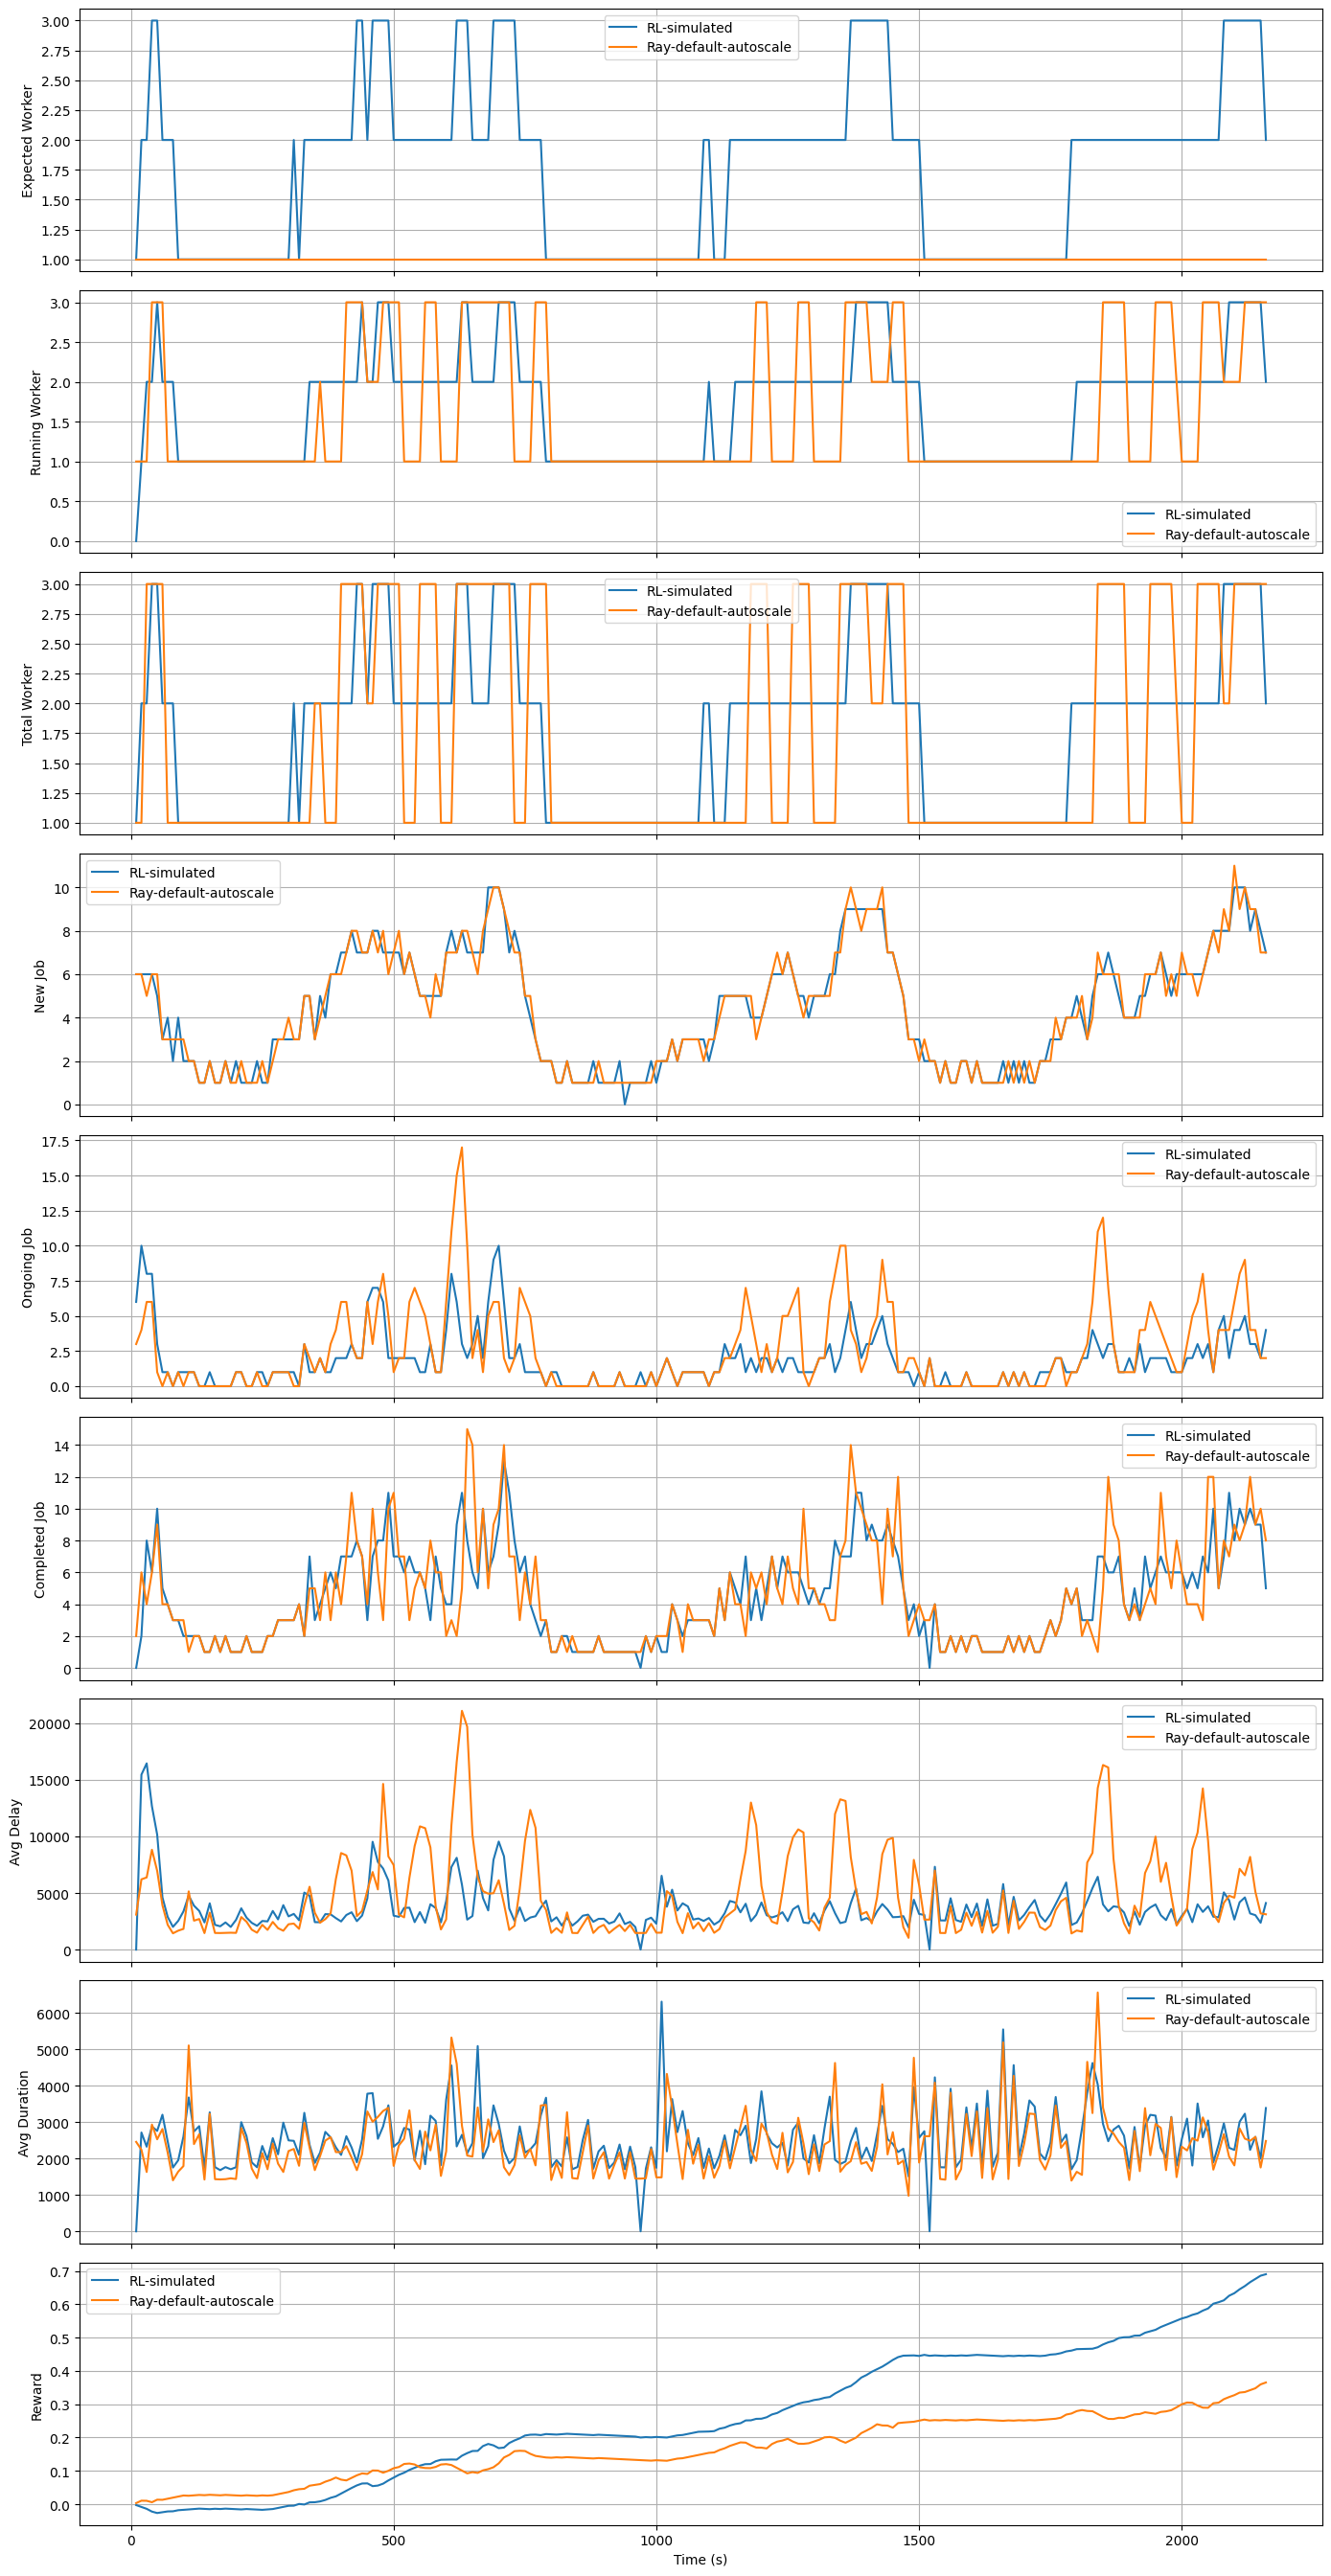

In [3]:
compare_metrics(
    preprocess_experiment_result('rl/tmp/metrics.csv'),
    pd.read_csv('../experiment/result/ray-test-metrics.csv'),
    label1='RL-simulated',
    label2='Ray-default-autoscale'
)

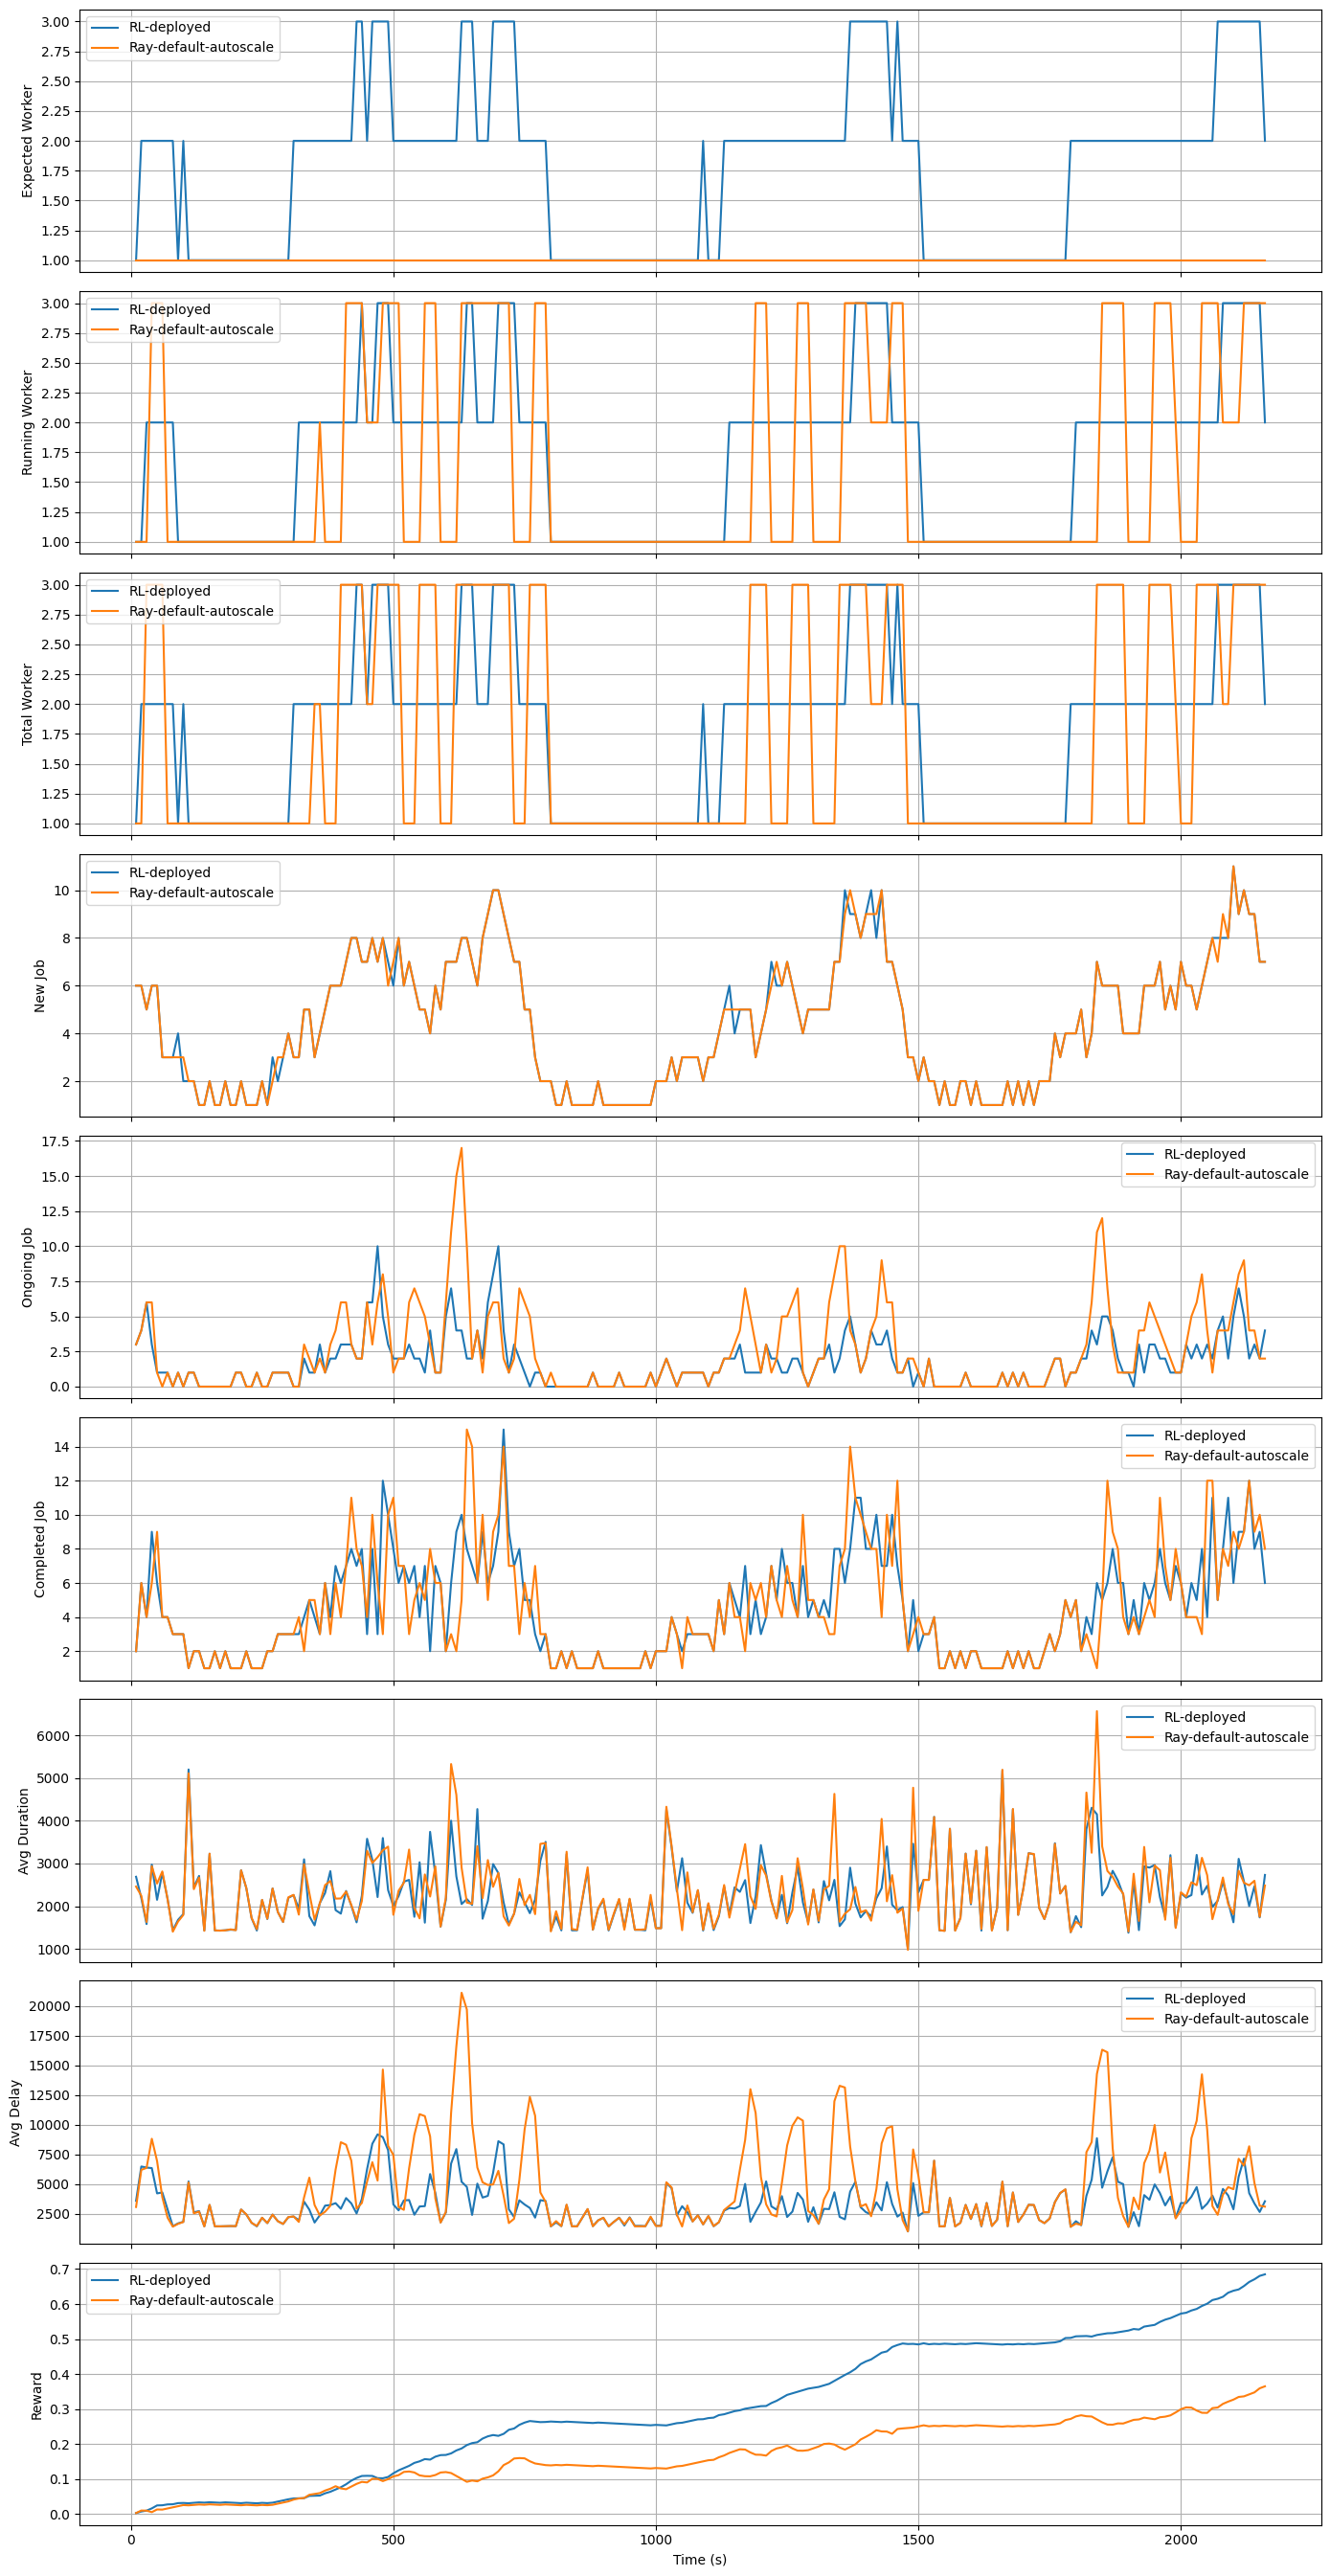

In [10]:
compare_metrics(
    pd.read_csv('../experiment/result/rl-test-metrics.csv'),
    pd.read_csv('../experiment/result/ray-test-metrics.csv'),
    label1='RL-deployed',
    label2='Ray-default-autoscale'
)

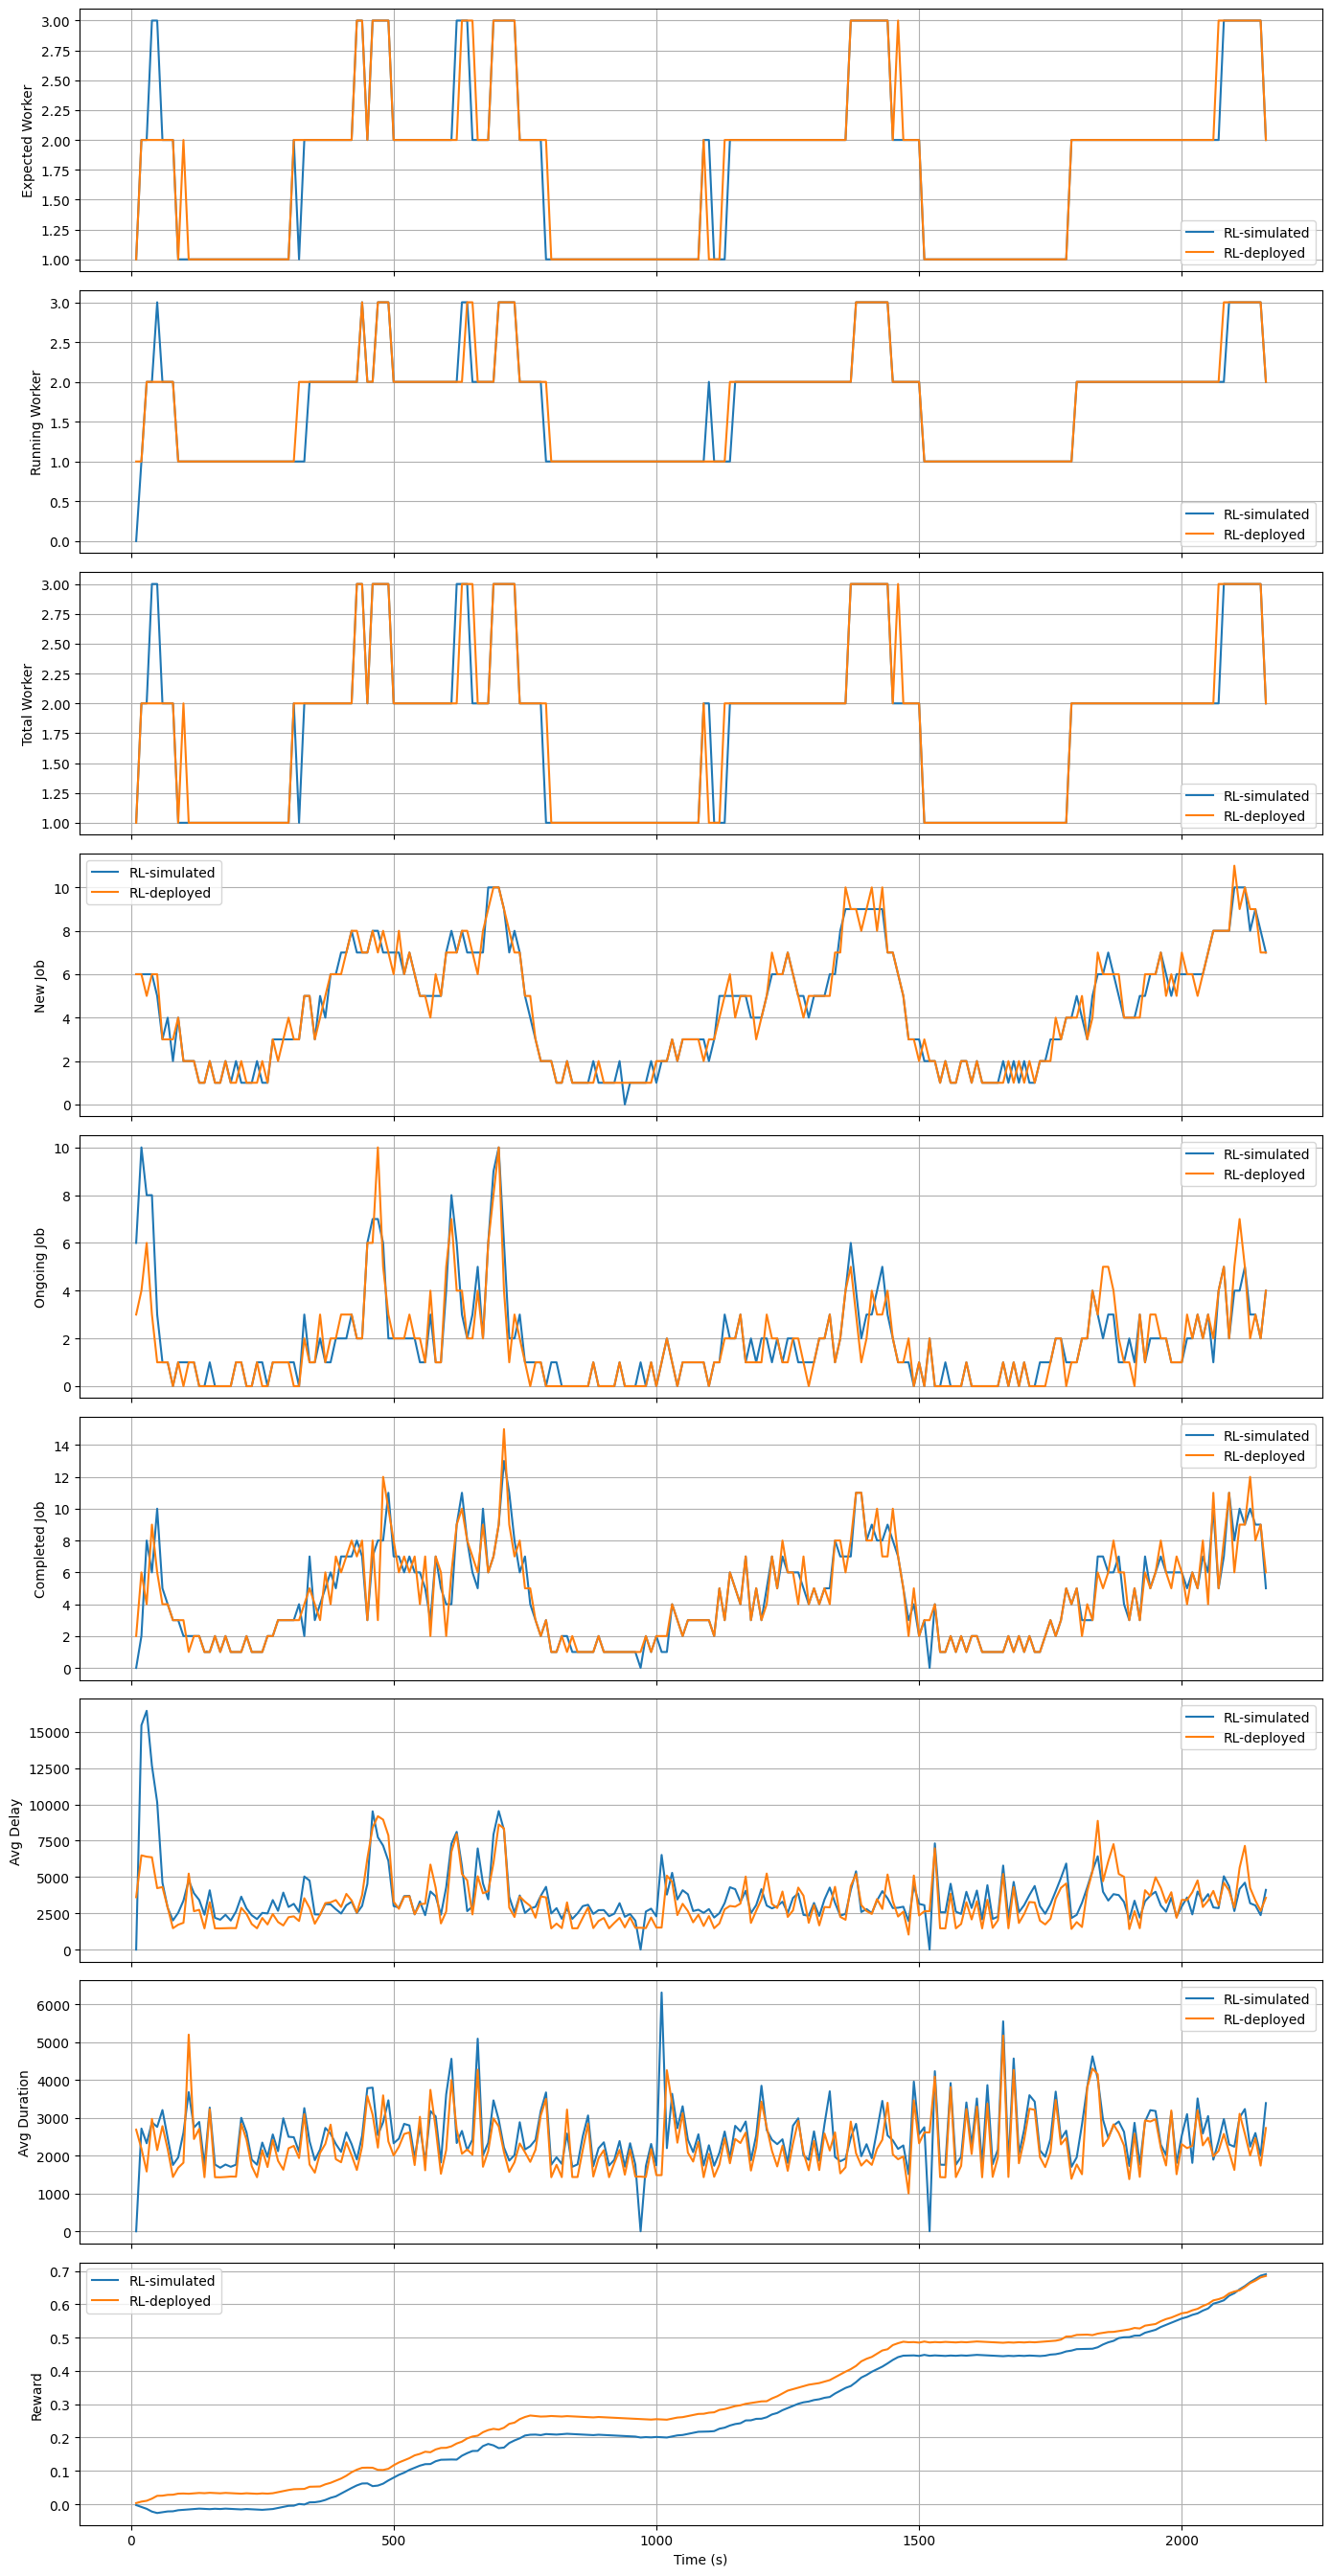

In [ ]:
compare_metrics(
    preprocess_experiment_result('rl/tmp/metrics.csv'),
    pd.read_csv('../experiment/result/rl-test-metrics.csv'),
    label1='RL-simulated',
    label2='RL-deployed'
)